## Data Wrangling

### Imports

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, f_oneway
from itertools import combinations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
import pmdarima as pm


# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Ray imports
import ray
from ray import tune
from ray.train import ScalingConfig, FailureConfig
from ray.train.torch import TorchTrainer
from ray.air import session, RunConfig
from ray.train import Checkpoint
from ray.tune.tune_config import TuneConfig
from ray.tune.schedulers import ASHAScheduler

import os
import tempfile
import pathlib
import random
import pickle
import warnings
warnings.filterwarnings('ignore')

### Load the Data

In [3]:
df = pd.read_csv('sales.csv').drop(columns='Row ID')

In [5]:
df.shape

(9800, 17)

In [7]:
df.head()

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


### Explore the Data

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Order ID       9800 non-null   object 
 1   Order Date     9800 non-null   object 
 2   Ship Date      9800 non-null   object 
 3   Ship Mode      9800 non-null   object 
 4   Customer ID    9800 non-null   object 
 5   Customer Name  9800 non-null   object 
 6   Segment        9800 non-null   object 
 7   Country        9800 non-null   object 
 8   City           9800 non-null   object 
 9   State          9800 non-null   object 
 10  Postal Code    9789 non-null   float64
 11  Region         9800 non-null   object 
 12  Product ID     9800 non-null   object 
 13  Category       9800 non-null   object 
 14  Sub-Category   9800 non-null   object 
 15  Product Name   9800 non-null   object 
 16  Sales          9800 non-null   float64
dtypes: float64(2), object(15)
memory usage: 1.3+ MB


We can see that Postal Code has some missing values, but grouping by Postal Code, City, or State would likely make the data too sparse to detect trends, so we won't bother with these features at all.

In [11]:
df.describe()

,Postal Code,Sales
count,9789.000000,9800.000000
mean,55273.322403,230.769059
std,32041.223413,626.651875
min,1040.000000,0.444000
25%,23223.000000,17.248000
50%,58103.000000,54.490000
75%,90008.000000,210.605000
max,99301.000000,22638.480000


#### Choosing a Time Interval

Our goal is to use time series analysis to predict Sales, so let's first determine an appropriate time interval.

In [14]:
# Convert 'Order Date' to datetime and set as index
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%d/%m/%Y')
df.set_index('Order Date', inplace=True)
df = df.sort_index()

In [16]:
# Create time-based features
df['Year'] = df.index.year
df['Month'] = df.index.month
df['Day'] = df.index.day
df['Weekday'] = df.index.weekday
df['Week'] = df.index.isocalendar().week
df['Quarter'] = df.index.quarter
df['Is Weekend'] = df['Weekday'].isin([5,6]).astype(int)

## Exploratory Data Analysis (EDA)

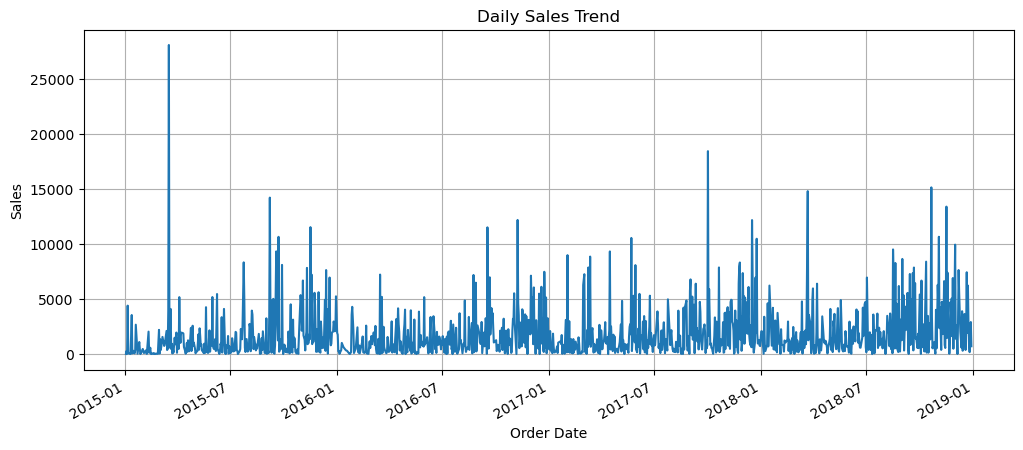

In [18]:
# Plot daily sales
plt.figure(figsize=(12, 5))
df.groupby(df.index)['Sales'].sum().plot(title='Daily Sales Trend')
plt.ylabel('Sales')
plt.grid()
plt.show()

Outliers will likely be problematic for analysis, so it's best to address them here.

In [20]:
Q1 = df['Sales'].quantile(0.25)
Q3 = df['Sales'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
   
# Cap the outliers
df['Sales'] = df['Sales'].clip(lower=lower_bound, upper=upper_bound)

Capping the outliers sets them to a maximum value rather than removing them altogether. This is a safer way of dealing with them while still retaining the data.

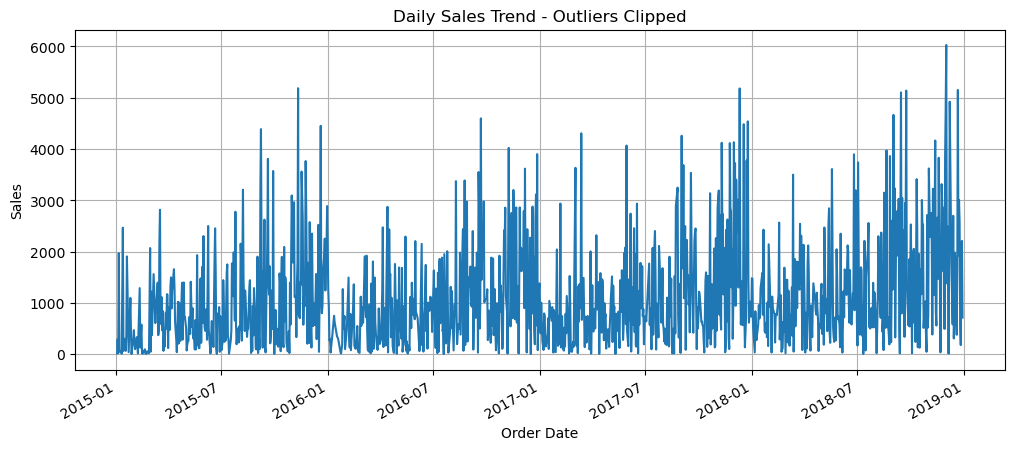

In [22]:
# Plot daily sales
plt.figure(figsize=(12, 5))
df.groupby(df.index)['Sales'].sum().plot(title='Daily Sales Trend - Outliers Clipped')
plt.ylabel('Sales')
plt.grid()
plt.show()

The daily sales trend plot has a lot of variability that makes interpretability difficult.

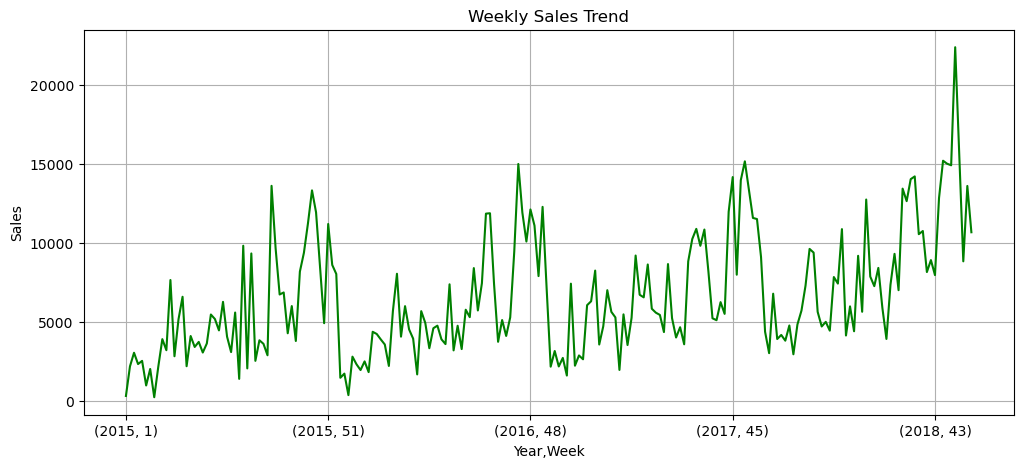

In [24]:
# Plot weekly sales
plt.figure(figsize=(12,5))
df.groupby(['Year', 'Week'])['Sales'].sum().plot(title='Weekly Sales Trend', color='green')
plt.ylabel('Sales')
plt.grid()
plt.show()

The weekly plot looks better, but patterns are still hard to detect.

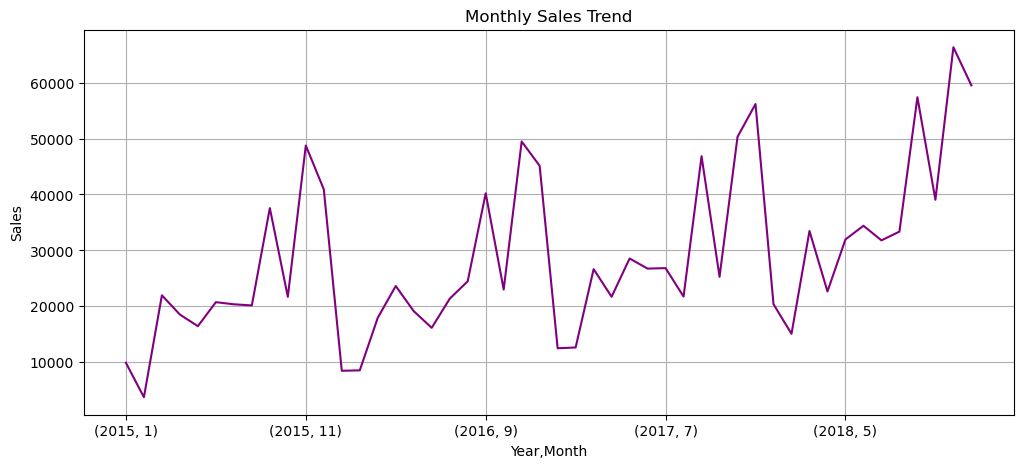

In [26]:
# Plot monthly sales
plt.figure(figsize=(12,5))
df.groupby(['Year', 'Month'])['Sales'].sum().plot(title='Monthly Sales Trend', color='purple')
plt.ylabel('Sales')
plt.grid()
plt.show()

In the monthly plot, sales appear to be increasing steadily over time. There are also obvious seasonality trends - sales hit annual minimums in January/February and have consistent spikes in September, November, and December.

The Coefficient of Variation (CV) is a good tool to help with deciding which interval to use. A CV < 0.5 indicates the data is stable and, therefore, daily trends are useful. If 0.5 <= CV < 1.0, weekly trends are useful. And finally, CV >= 1.0 indicates monthly trends being the best option.

In [26]:
cv = df['Sales'].std() / df['Sales'].mean()
print(f"Coefficient of Variation: {cv:.2f}")

Coefficient of Variation: 1.20


The plots and CV agree - monthly time grouping is the best option here.

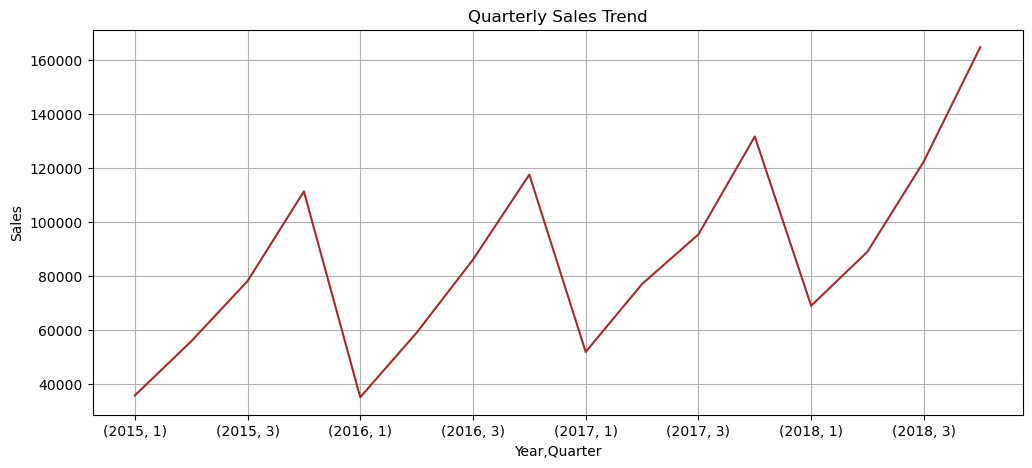

In [28]:
# Plot quarterly sales
plt.figure(figsize=(12,5))
df.groupby(['Year', 'Quarter'])['Sales'].sum().plot(title='Quarterly Sales Trend', color='brown')
plt.ylabel('Sales')
plt.grid()
plt.show()

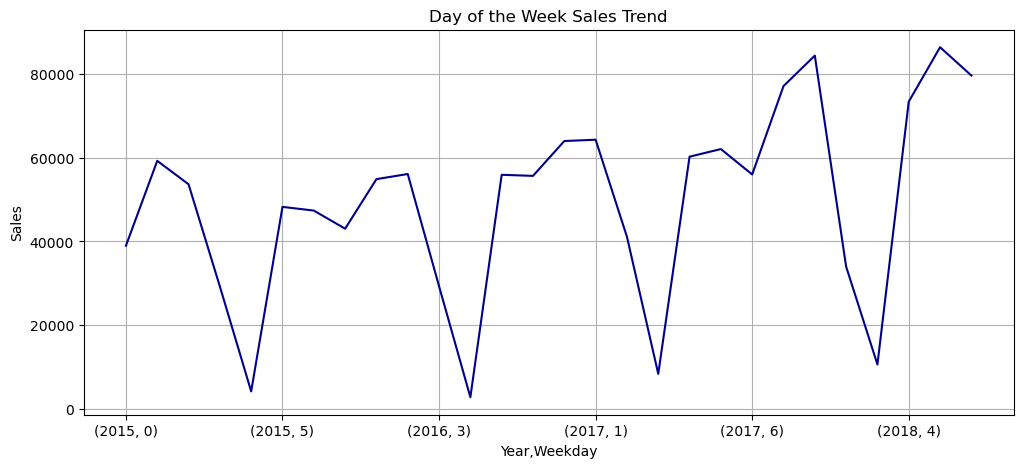

In [32]:
# Plot sales trend for day of week 
plt.figure(figsize=(12, 5))
df.groupby(['Year', 'Weekday'])['Sales'].sum().plot(title='Day of the Week Sales Trend', color='darkblue')
plt.ylabel('Sales')
plt.grid()
plt.show()

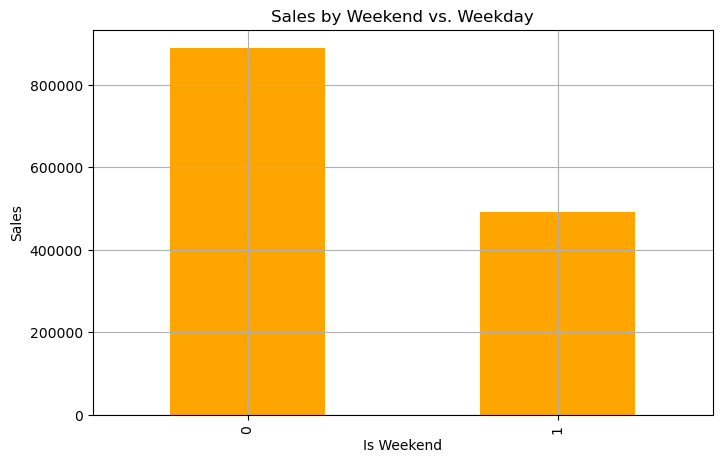

In [34]:
plt.figure(figsize=(8, 5))
df.groupby('Is Weekend')['Sales'].sum().plot(kind='bar', title='Sales by Weekend vs. Weekday', color='orange')
plt.ylabel('Sales')
plt.grid()
plt.show()

#### Target Feature Transformation

Let's take a quick look at the target feature, sales.

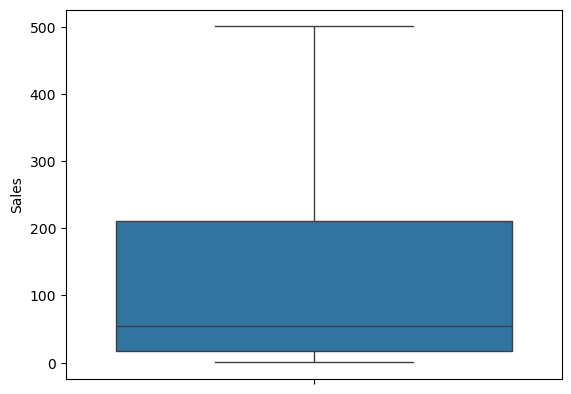

In [36]:
sns.boxplot(data=df, y='Sales')
plt.show()

#### Categorical Features

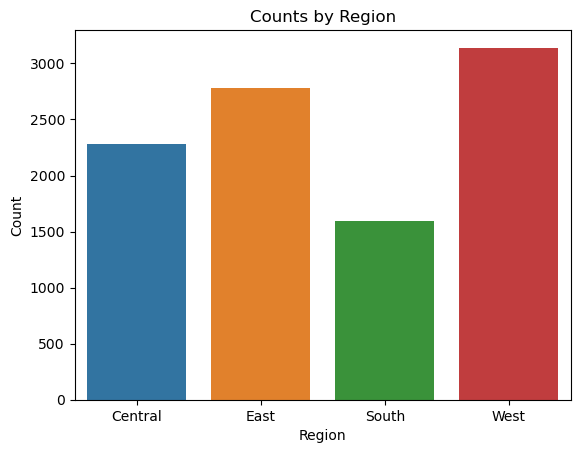

In [38]:
sns.countplot(data=df, x='Region', hue='Region')
plt.title('Counts by Region')
plt.xlabel('Region')
plt.ylabel('Count')
plt.show()

We see that the West region has the highest count, followed by East, and South with the least.

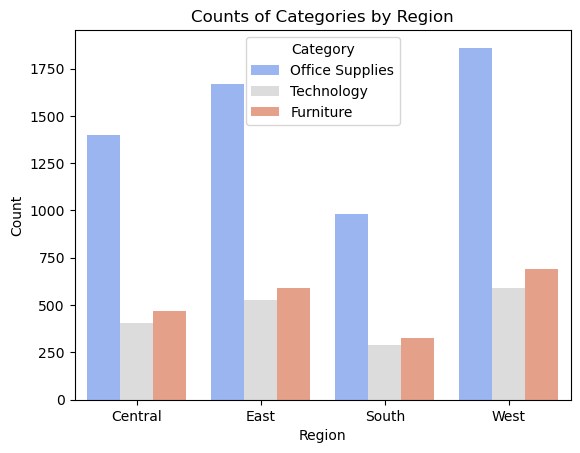

In [40]:
sns.countplot(data=df, x='Region', hue='Category', palette='coolwarm')
plt.title('Counts of Categories by Region')
plt.xlabel('Region')
plt.ylabel('Count')
plt.show()

The above plot shows us the breakdown of each region by category. We can see the South region has the smallest frequencies across every category. Also, regardless of region, office supplies make up the largest proportion of sales.

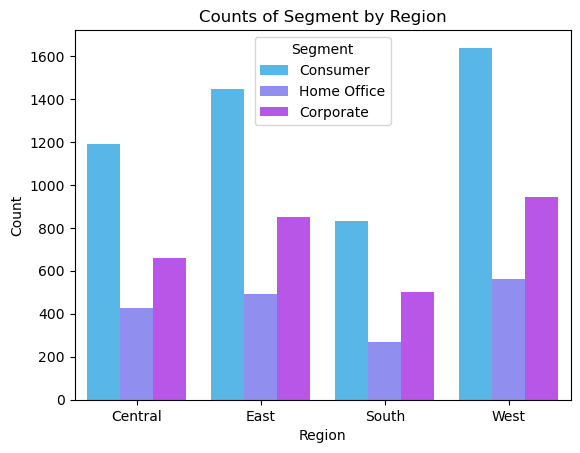

In [42]:
sns.countplot(data=df, x='Region', hue='Segment', palette='cool')
plt.title('Counts of Segment by Region')
plt.xlabel('Region')
plt.ylabel('Count')
plt.show()

Proportions seem to be very similar by segment for region as well. And, just as above, the South region has the smallest frequencies across all segments.  
Next, we can perform some Chi-Square Tests of Independence to see if the categorical features of interest are associated.

In [73]:
cols = ['Region', 'Segment', 'Category']
pairs = list(combinations(cols, 2))
results = {}

for col1, col2 in pairs:
    con_table = pd.crosstab(df[col1], df[col2])
    chi2, p, dof, expected = chi2_contingency(con_table)
    results[(col1, col2)] = {'Chi-Square': chi2, 'p-value': p, 'Degrees of Freedom': dof, 'Expected Frequencies': expected}

for pair, result in results.items():
    print(f"\nChi-Square Test between {pair[0]} and {pair[1]}:")
    print(f"Chi-Square Statistic: {result['Chi-Square']}")
    print(f"P-value: {result['p-value']}")
    print(f"Degrees of Freedom: {result['Degrees of Freedom']}")
    print(f"Expected Frequencies:\n{result['Expected Frequencies']}")


Chi-Square Test between Region and Segment:
Chi-Square Statistic: 4.20752335551208
P-value: 0.6486157291560657
Degrees of Freedom: 6
Expected Frequencies:
[[1185.20173469  686.1205102   405.6777551 ]
 [1449.62091837  839.19438776  496.18469388]
 [ 831.77530612  481.51979592  284.70489796]
 [1634.40204082  946.16530612  559.43265306]]

Chi-Square Test between Region and Category:
Chi-Square Statistic: 4.290472977284262
P-value: 0.6374317692943314
Degrees of Freedom: 6
Expected Frequencies:
[[ 482.81693878 1372.93806122  421.245     ]
 [ 590.53367347 1679.24132653  515.225     ]
 [ 338.84122449  963.52877551  295.63      ]
 [ 665.80816327 1893.29183673  580.9       ]]

Chi-Square Test between Segment and Category:
Chi-Square Statistic: 1.1483084048410648
P-value: 0.8865337450386218
Degrees of Freedom: 4
Expected Frequencies:
[[1081.62020408 3075.69479592  943.685     ]
 [ 626.15653061 1780.53846939  546.305     ]
 [ 370.22326531 1052.76673469  323.01      ]]


All expected frequencies are > 5, implying the validity of all chi-square test results. Furthermore, all p-values are > 0.05, indicating a failure to reject the null hypothesis, i.e., the categorical variables of interest are independent.  

#### Relationships of Categorical Features to Target Feature

Now can we can inspect our categorical features with respect to the target feature, Log_Sales.

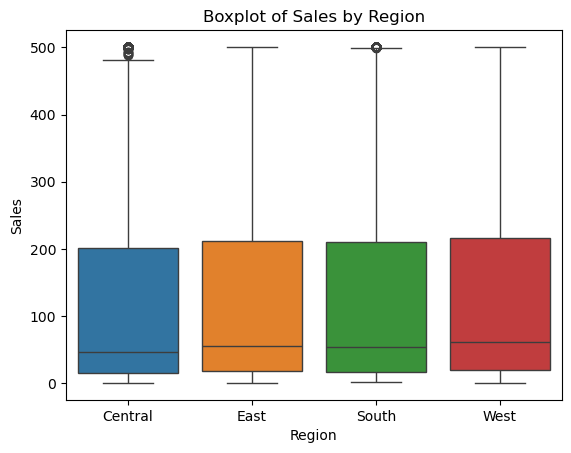

In [118]:
sns.boxplot(x='Region', y='Sales', hue='Region', data=df)
plt.title('Boxplot of Sales by Region')
plt.show()

The West region has a slightly narrower distribution than the others and all regions have a similar median value.

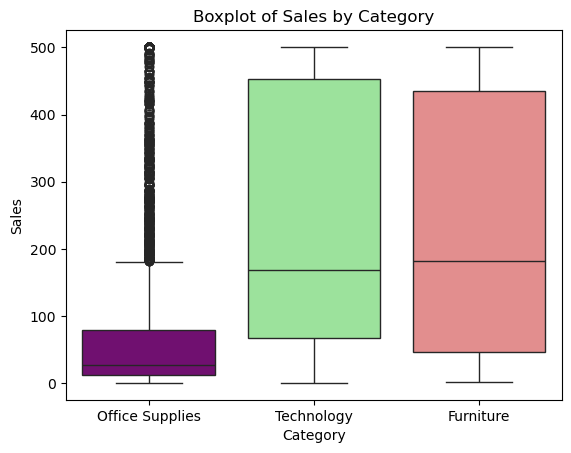

In [120]:
custom=['#800080', '#90EE90', '#F08080']
sns.boxplot(x='Category', y='Sales', hue='Category', palette=custom, data=df)
plt.title('Boxplot of Sales by Category')
plt.show()

Office supplies have a lower median value compared to furniture or technology, which is expected for obvious reasons.

In [85]:
for i in df['Category'].unique():
    print('Total sales for', i, 'amount to:', f'${df['Sales'][df['Category'] == i].sum():,.2f}')

Total sales for Office Supplies amount to: $484,165.78
Total sales for Technology amount to: $422,664.54
Total sales for Furniture amount to: $473,164.42


In [87]:
df.groupby('Category')['Sales'].mean()

Category
Furniture          227.701840
Office Supplies     81.937007
Technology         233.129918
Name: Sales, dtype: float64

We can see that office supplies have the lowest grand total and much lower average sale price.

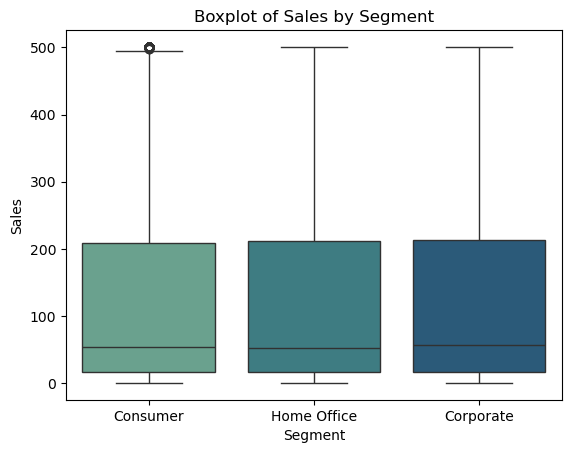

In [122]:
sns.boxplot(x='Segment', y='Sales', hue='Segment', palette='crest', data=df)
plt.title("Boxplot of Sales by Segment")
plt.show()

By segment, all boxplots look nearly identical. This feature may not be useful for analysis, but we will keep it for now.  

The analog to Chi-Square tests for categorical variables is a One-Way ANOVA for a numerical dependent variable with categorical independent variables.

In [97]:
for col in cols:
    groups = [df['Sales'][df[col] == value] for value in df[col].unique()]
    f_stat, p_value = f_oneway(*groups)
    print(f'ANOVA for {col} - F-statistic: {f_stat}, P-value: {p_value}')

ANOVA for Region - F-statistic: 1.487969169955466, P-value: 0.21560371773426887
ANOVA for Segment - F-statistic: 0.4633060804380507, P-value: 0.6292138022853977
ANOVA for Category - F-statistic: 1099.0728574534662, P-value: 0.0


The ANOVA results agree with the boxplots above - none of the groups from Segment or Region are significantly different from one another, but Category has at least one group mean that is significantly different from its remaining group means.

#### Time Trends

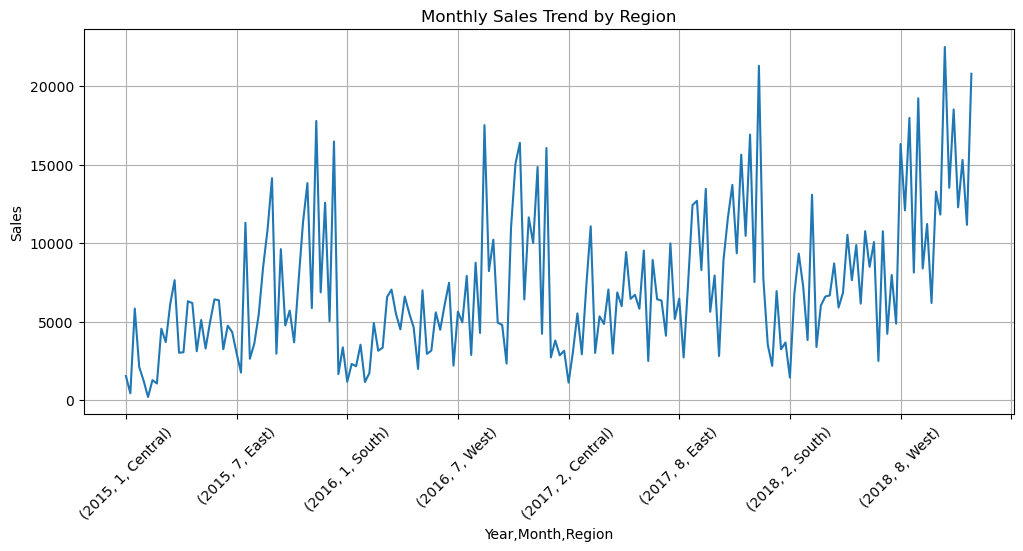

In [44]:
plt.figure(figsize=(12, 5))
df.groupby(['Year', 'Month', 'Region'])['Sales'].sum().plot(title='Monthly Sales Trend by Region')
plt.ylabel('Sales')
plt.grid()
plt.xticks(rotation=45)
plt.show()

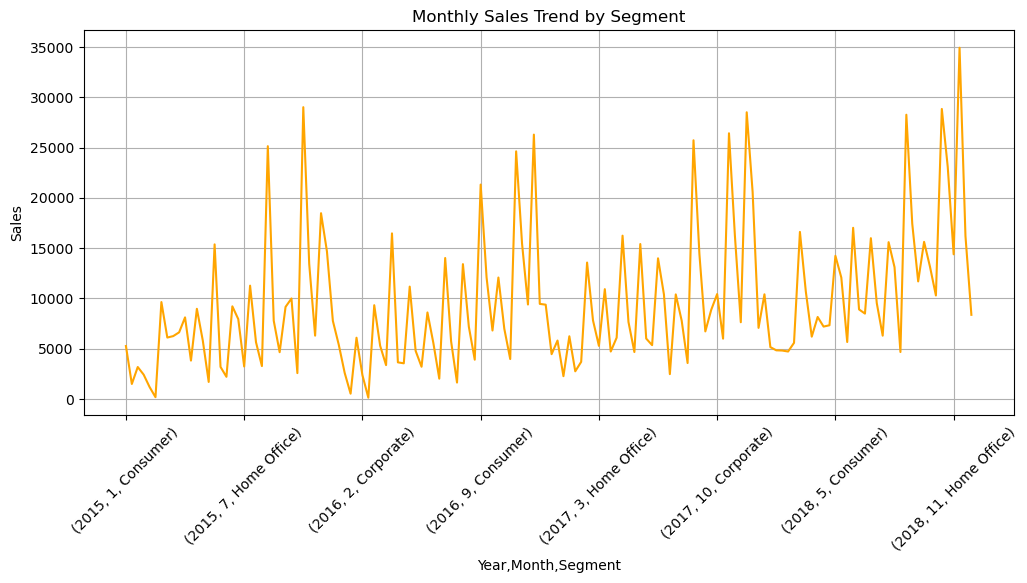

In [46]:
plt.figure(figsize=(12, 5))
df.groupby(['Year', 'Month', 'Segment'])['Sales'].sum().plot(title='Monthly Sales Trend by Segment', color='orange')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.grid()
plt.show()

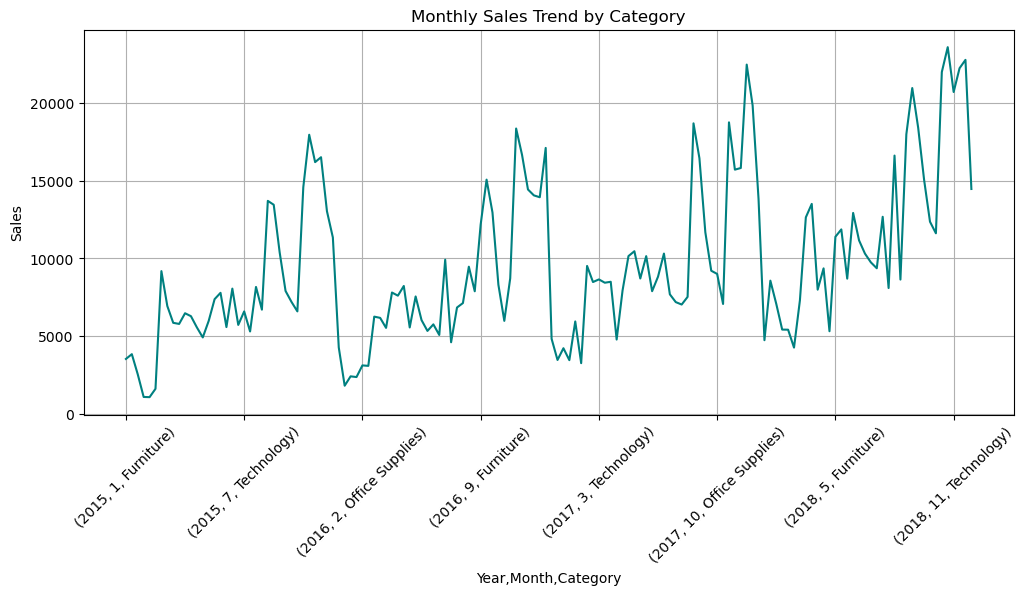

In [48]:
plt.figure(figsize=(12, 5))
df.groupby(['Year', 'Month', 'Category'])['Sales'].sum().plot(title='Monthly Sales Trend by Category', color='teal')
plt.ylabel('Sales')
plt.grid()
plt.xticks(rotation=45)
plt.show()

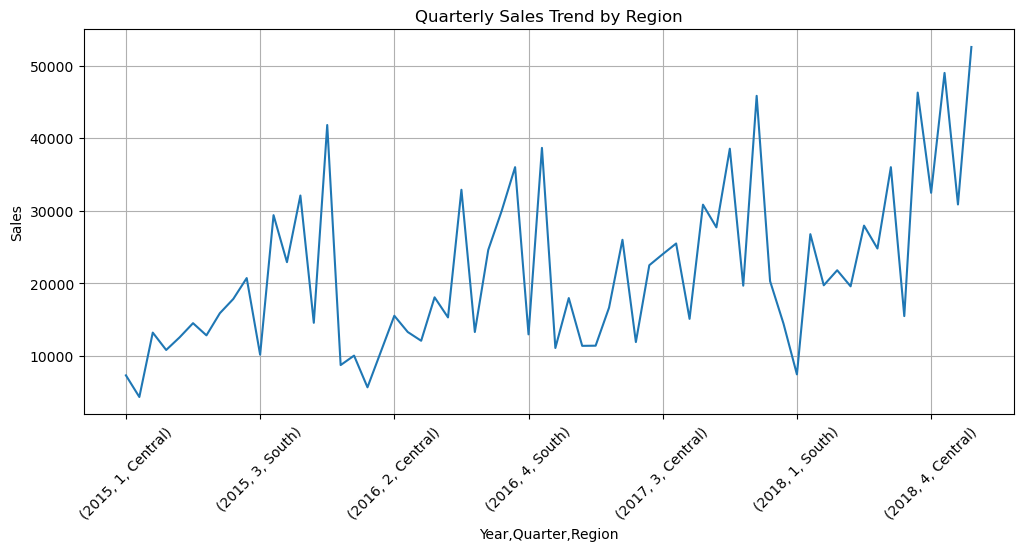

In [106]:
plt.figure(figsize=(12, 5))
df.groupby(['Year', 'Quarter', 'Region'])['Sales'].sum().plot(title='Quarterly Sales Trend by Region')
plt.ylabel('Sales')
plt.grid()
plt.xticks(rotation=45)
plt.show()

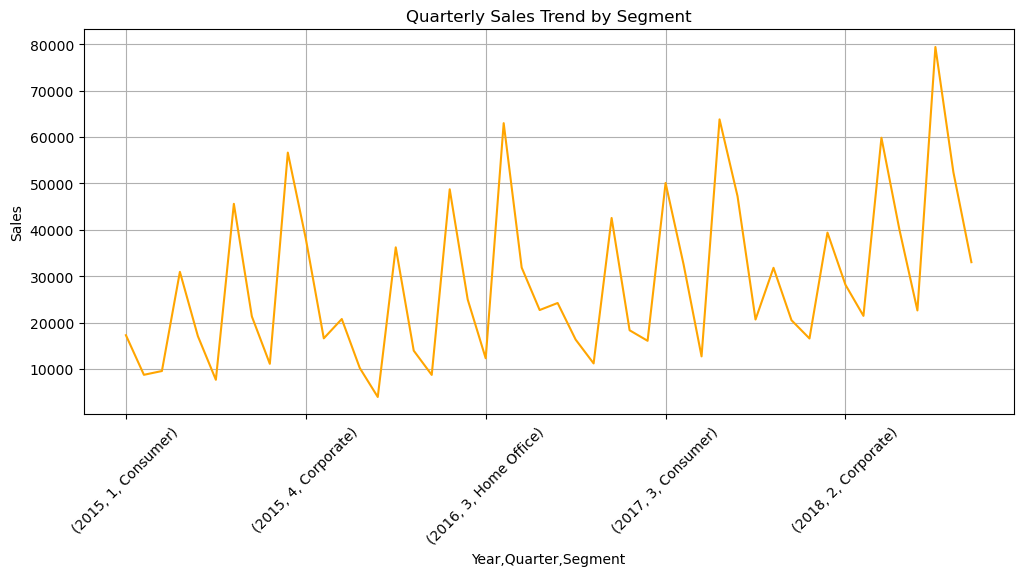

In [108]:
plt.figure(figsize=(12, 5))
df.groupby(['Year', 'Quarter', 'Segment'])['Sales'].sum().plot(title='Quarterly Sales Trend by Segment', color='orange')
plt.ylabel('Sales')
plt.grid()
plt.xticks(rotation=45)
plt.show()

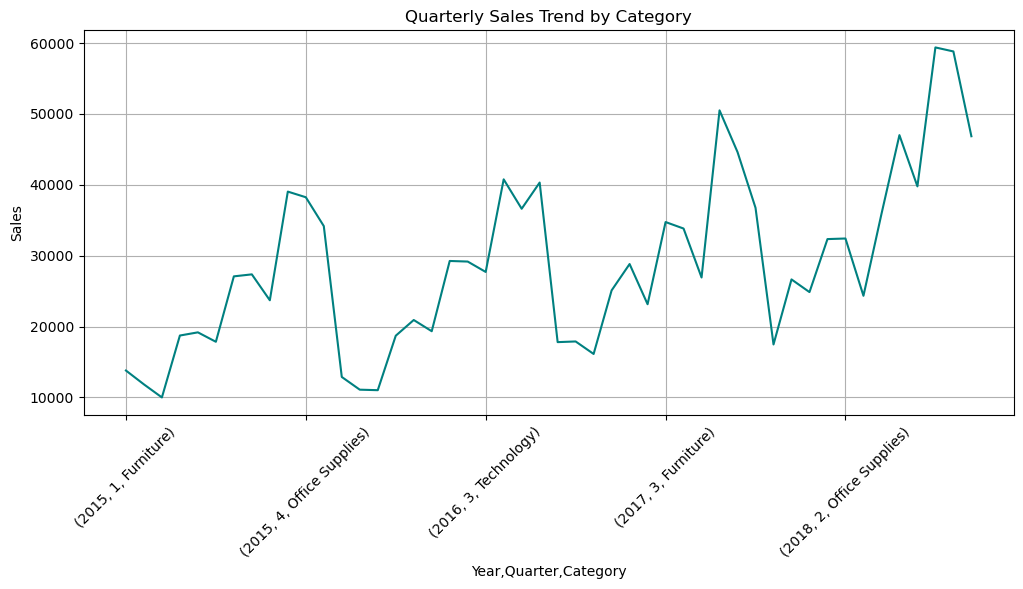

In [110]:
plt.figure(figsize=(12, 5))
df.groupby(['Year', 'Quarter', 'Category'])['Sales'].sum().plot(title='Quarterly Sales Trend by Category', color='teal')
plt.ylabel('Sales')
plt.grid()
plt.xticks(rotation=45)
plt.show()

Monthly and quarterly sales trends by Region, Segment, and Category all appear to have repeating patterns.

### Tests for Autocorrelation and Stationarity

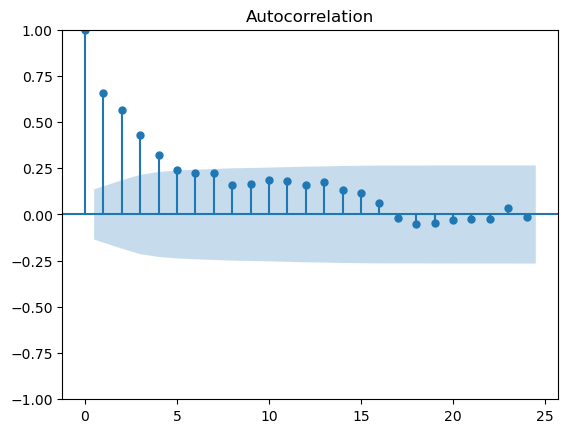

In [30]:
df_resampled = df['Sales'].resample('W').sum()
plot_acf(df_resampled.dropna())
plt.show()

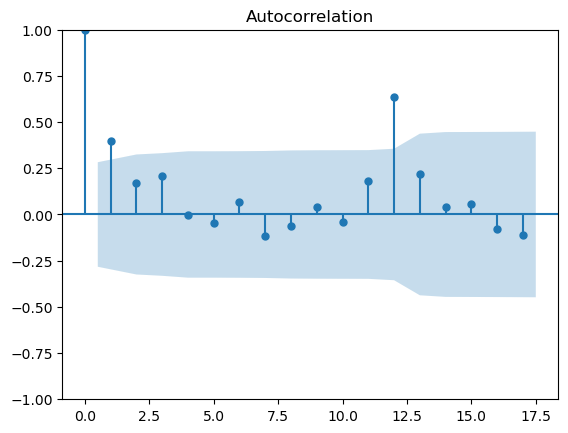

In [32]:
df_resampled = df['Sales'].resample('ME').sum()
plot_acf(df_resampled.dropna())
plt.show()

We can see that lags 1-4 show significant autocorrelation for weekly resampled data, whereas lags 1 and 12 are significant for monthly resampling.  
We will focus on monthly trends and seasonality, but it is good to know we can explore weekly trends should there be a desire for a finer granularity.

In [34]:
# Perform the ADF test
result = adfuller(df_resampled)

# Output the test statistic and p-value
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -4.01393902075849
p-value: 0.0013392557080076643


With a p-value of 0.001, the Augmented Dickey-Fuller test results indicate our monthly resample data is stationary.

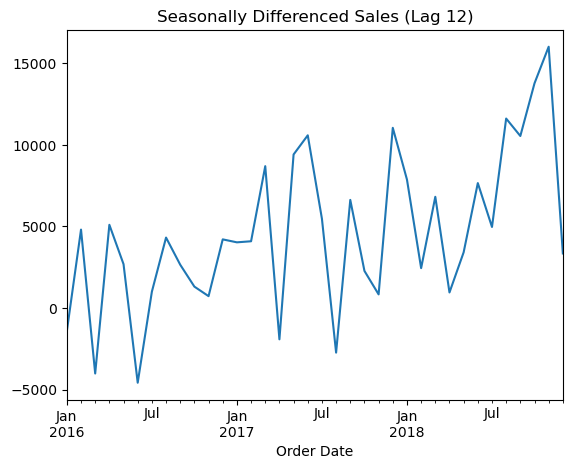

ADF Statistic (Seasonal Differenced): -4.651064282273594
p-value: 0.00010389044229710069


In [36]:
# Seasonal differencing
df_seasonal_diff = df_resampled - df_resampled.shift(12)
df_seasonal_diff = df_seasonal_diff.dropna()

df_seasonal_diff.plot(title="Seasonally Differenced Sales (Lag 12)")
plt.show()

result = adfuller(df_seasonal_diff)

print("ADF Statistic (Seasonal Differenced):", result[0])
print("p-value:", result[1])

The seasonally differenced data is also stationary.

To prepare the df for one-hot encoding, we can remove features that are too granular to be useful - this will greatly reduce the number of generated features.

In [38]:
# Keep useful categorical variables
df = df[['Segment', 'Region', 'Category', 'Year', 'Month', 'Day', 'Weekday', 'Week', 'Quarter', 'Is Weekend', 'Sales']]

In [40]:
df

,Segment,Region,Category,Year,Month,Day,Weekday,Week,Quarter,Is Weekend,Sales
Order Date,,,,,,,,,,,
2015-01-03,Consumer,Central,Office Supplies,2015,1,3,5,1,1,1,16.448
2015-01-04,Home Office,Central,Office Supplies,2015,1,4,6,1,1,1,3.540
2015-01-04,Home Office,Central,Office Supplies,2015,1,4,6,1,1,1,272.736
2015-01-04,Home Office,Central,Office Supplies,2015,1,4,6,1,1,1,11.784
2015-01-05,Consumer,East,Office Supplies,2015,1,5,0,2,1,0,19.536
...,...,...,...,...,...,...,...,...,...,...,...
2018-12-30,Corporate,West,Office Supplies,2018,12,30,6,52,4,1,20.720
2018-12-30,Consumer,East,Furniture,2018,12,30,6,52,4,1,323.136
2018-12-30,Home Office,Central,Office Supplies,2018,12,30,6,52,4,1,209.300


In [116]:
df.to_csv('sales_cleaned.csv')

## Pre-Processing

### Load the Data

In [42]:
df = pd.read_csv('sales_cleaned.csv', index_col='Order Date', parse_dates=True).sort_index()

In [44]:
df.shape

(9800, 11)

In [46]:
df.head()

,Segment,Region,Category,Year,Month,Day,Weekday,Week,Quarter,Is Weekend,Sales
Order Date,,,,,,,,,,,
2015-01-03,Consumer,Central,Office Supplies,2015,1,3,5,1,1,1,16.448
2015-01-04,Home Office,Central,Office Supplies,2015,1,4,6,1,1,1,3.540
2015-01-04,Home Office,Central,Office Supplies,2015,1,4,6,1,1,1,272.736
2015-01-04,Home Office,Central,Office Supplies,2015,1,4,6,1,1,1,11.784
2015-01-05,Consumer,East,Office Supplies,2015,1,5,0,2,1,0,19.536


### Resampling & One-Hot Encoding

Creating a custom function to handle the delicate process of resampling the data can be helpful for preparing data for different models. We must separate and aggregate column types individually to avoid illogical sums or concatenations of strings when resampling. We will also create dummy variables for categorical features, ensure all encoded columns exist (important for neural nets), and convert all boolean values to integers. Finally, we merge the results back together.

In [48]:
def preprocess(df, resample_data=True, freq='ME', drop_first=True):
    df = df.copy()
    
    # Columns
    metric_cols = ['Sales']
    cat_cols = ['Category']
    time_cols = ['Year', 'Month', 'Day', 'Weekday', 'Week', 'Quarter', 'Is Weekend']

    # Optional resampling for SARIMA/SARIMAX
    if resample_data:
        # Prepare expected dummy columns before resampling
        expected_dummies = pd.get_dummies(df[cat_cols], drop_first=drop_first).columns.tolist()

        # Custom mode aggregation
        def mode_agg(x):
            mode_val = x.mode()
            return mode_val[0] if not mode_val.empty else np.nan

        agg_dict = {
            **{col: 'sum' for col in metric_cols},
            **{col: mode_agg for col in time_cols + cat_cols}
        }

        df = df[metric_cols + time_cols + cat_cols].resample(freq).agg(agg_dict)

    # One-hot encode categorical variables
    df = pd.get_dummies(df, columns=cat_cols, drop_first=drop_first)

    # Fill missing dummies from resample (if any)
    if resample_data:
        for col in expected_dummies:
            if col not in df.columns:
                df[col] = 0

    # Convert booleans to integers
    bool_cols = df.select_dtypes(include='bool').columns
    df[bool_cols] = df[bool_cols].astype(int)

    return df

### Model-Specific Prep

#### SARIMA

In [50]:
# Only Sales for SARIMA
df_sarima = preprocess(df)['Sales']

In [52]:
df_sarima

Order Date
2015-01-31     9912.7315
2015-02-28     3764.3125
2015-03-31    21980.1340
2015-04-30    18542.3085
2015-05-31    16460.4170
2015-06-30    20751.6071
2015-07-31    20371.5965
2015-08-31    20172.5380
2015-09-30    37564.4618
2015-10-31    21706.3450
2015-11-30    48747.4302
2015-12-31    40913.8830
2016-01-31     8490.7590
2016-02-29     8568.0125
2016-03-31    17962.2920
2016-04-30    23640.7010
2016-05-31    19146.1465
2016-06-30    16168.9850
2016-07-31    21369.5795
2016-08-31    24488.1942
2016-09-30    40216.1980
2016-10-31    23014.5500
2016-11-30    49471.7103
2016-12-31    45118.6860
2017-01-31    12514.0810
2017-02-28    12656.7335
2017-03-31    26654.6775
2017-04-30    21717.9490
2017-05-31    28555.6425
2017-06-30    26753.0510
2017-07-31    26835.9235
2017-08-31    21750.2563
2017-09-30    46840.1585
2017-10-31    25285.3030
2017-11-30    50303.7435
2017-12-31    56162.6780
2018-01-31    20385.8515
2018-02-28    15096.6884
2018-03-31    33470.2723
2018-04-30    

#### SARIMAX

In [60]:
df_sarimax = preprocess(df)

# Add cyclical encoding for time variables with SARIMAX
df_sarimax['Month_sin'] = np.sin(2 * np.pi * df_sarimax['Month'] / 12)
df_sarimax['Month_cos'] = np.cos(2 * np.pi * df_sarimax['Month'] / 12)

df_sarimax['Weekday_sin'] = np.sin(2 * np.pi * df_sarimax['Weekday'] / 7)
df_sarimax['Weekday_cos'] = np.cos(2 * np.pi * df_sarimax['Weekday'] / 7)

# Create lags and rolling stats
df_sarimax['Lag_1'] = df_sarimax['Sales'].shift(1)
df_sarimax['Lag_12'] = df_sarimax['Sales'].shift(12)
df_sarimax['Rolling_Mean_3'] = df_sarimax['Sales'].rolling(window=3).mean()
df_sarimax['Rolling_Std_3'] = df_sarimax['Sales'].rolling(window=3).std()
df_sarimax['Rolling_Mean_12'] = df_sarimax['Sales'].rolling(window=12).mean()
df_sarimax['Rolling_Std_12'] = df_sarimax['Sales'].rolling(window=12).std()
df_sarimax.dropna(inplace=True)

In [62]:
# Drop features already captured or unnecessary
df_sarimax.drop(columns=['Month', 'Weekday', 'Day', 'Week', 'Quarter', 'Year', 'Is Weekend'], inplace=True)

In [64]:
df_sarimax

,Sales,Category_Office Supplies,Category_Technology,Month_sin,Month_cos,Weekday_sin,Weekday_cos,Lag_1,Lag_12,Rolling_Mean_3,Rolling_Std_3,Rolling_Mean_12,Rolling_Std_12
Order Date,,,,,,,,,,,,,
2016-01-31,8490.7590,0,0,5.000000e-01,8.660254e-01,-0.974928,-0.222521,40913.8830,9912.7315,32717.357400,21343.316705,23288.816050,13006.288099
2016-02-29,8568.0125,0,0,8.660254e-01,5.000000e-01,-0.974928,-0.222521,8490.7590,3764.3125,19324.218167,18697.238105,23689.124383,12411.035003
2016-03-31,17962.2920,0,0,1.000000e+00,6.123234e-17,0.781831,0.623490,8568.0125,21980.1340,11673.687833,5446.227942,23354.304217,12515.090509
2016-04-30,23640.7010,0,0,8.660254e-01,-5.000000e-01,0.000000,1.000000,17962.2920,18542.3085,16723.668500,7612.300952,23779.170258,12423.083285
2016-05-31,19146.1465,0,0,5.000000e-01,-8.660254e-01,0.781831,0.623490,23640.7010,16460.4170,20249.713167,2995.743102,24002.981050,12302.854975
2016-06-30,16168.9850,0,0,1.224647e-16,-1.000000e+00,-0.974928,-0.222521,19146.1465,20751.6071,19651.944167,3761.450313,23621.095875,12482.761466
2016-07-31,21369.5795,0,0,-5.000000e-01,-8.660254e-01,-0.974928,-0.222521,16168.9850,20371.5965,18894.903667,2609.384604,23704.261125,12462.451803
2016-08-31,24488.1942,0,0,-8.660254e-01,-5.000000e-01,0.781831,0.623490,21369.5795,20172.5380,20675.586233,4202.800307,24063.899142,12413.442725
2016-09-30,40216.1980,0,0,-1.000000e+00,-1.836970e-16,-0.974928,-0.222521,24488.1942,37564.4618,28691.323900,10101.904854,24284.877158,12696.007798


#### LSTM

While regression or cluster models require dropping the first dummy variable, we must specify to keep all dummy variables by setting the drop parameter of our custom function to False for LSTM.

In [66]:
df_lstm = preprocess(df, freq='W', drop_first=False)

# Add cyclical encodings
df_lstm['Month_sin'] = np.sin(2 * np.pi * df_lstm['Month'] / 12)
df_lstm['Month_cos'] = np.cos(2 * np.pi * df_lstm['Month'] / 12)
df_lstm['Weekday_sin'] = np.sin(2 * np.pi * df_lstm['Weekday'] / 7)
df_lstm['Weekday_cos'] = np.cos(2 * np.pi * df_lstm['Weekday'] / 7)

# Add t-1 through t-4 lags
for lag in range(1, 5):
    df_lstm[f'Sales_lag_{lag}'] = df_lstm['Sales'].shift(lag)
df_lstm.dropna(inplace=True)

# Drop raw data
df_lstm.drop(columns=['Month', 'Day', 'Weekday', 'Week', 'Quarter'], inplace=True)
#df_lstm.drop(columns=['Is Weekend', 'Category_Furniture', 'Category_Office Supplies', 'Category_Technology', 'Year', 'Month', 'Day', 'Weekday', 'Week', 'Quarter'], inplace=True)

In [68]:
df_lstm

,Sales,Year,Is Weekend,Category_Furniture,Category_Office Supplies,Category_Technology,Month_sin,Month_cos,Weekday_sin,Weekday_cos,Sales_lag_1,Sales_lag_2,Sales_lag_3,Sales_lag_4
Order Date,,,,,,,,,,,,,,
2015-02-01,2527.9140,2015,0,0,1,0,5.000000e-01,8.660254e-01,0.000000,1.000000,2325.9550,3041.9850,2181.2695,304.5080
2015-02-08,968.5340,2015,0,0,1,0,8.660254e-01,5.000000e-01,-0.433884,-0.900969,2527.9140,2325.9550,3041.9850,2181.2695
2015-02-15,2015.4745,2015,0,0,1,0,8.660254e-01,5.000000e-01,0.974928,-0.222521,968.5340,2527.9140,2325.9550,3041.9850
2015-02-22,224.9120,2015,0,0,1,0,8.660254e-01,5.000000e-01,-0.433884,-0.900969,2015.4745,968.5340,2527.9140,2325.9550
2015-03-01,2156.1675,2015,1,0,1,0,1.000000e+00,6.123234e-17,-0.781831,0.623490,224.9120,2015.4745,968.5340,2527.9140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-02,22398.6020,2018,1,0,1,0,-2.449294e-16,1.000000e+00,-0.974928,-0.222521,14919.0120,15018.5160,15206.9465,12842.7595
2018-12-09,15590.7695,2018,0,0,1,0,-2.449294e-16,1.000000e+00,-0.781831,0.623490,22398.6020,14919.0120,15018.5160,15206.9465
2018-12-16,8833.8585,2018,0,0,1,0,-2.449294e-16,1.000000e+00,0.000000,1.000000,15590.7695,22398.6020,14919.0120,15018.5160


Different time series models have different input needs. SARIMA/SARIMAX do not need scaling, but it is important for LSTM. 

In [70]:
features = df_lstm.drop(columns='Sales')

# Scale the features
lstm_scaler = MinMaxScaler()
scaled_features = pd.DataFrame(
    lstm_scaler.fit_transform(features),
    columns=features.columns,
    index=features.index
)

scaled_features['Sales'] = df_lstm['Sales']
df_lstm = scaled_features

In [72]:
df_lstm

,Year,Is Weekend,Category_Furniture,Category_Office Supplies,Category_Technology,Month_sin,Month_cos,Weekday_sin,Weekday_cos,Sales_lag_1,Sales_lag_2,Sales_lag_3,Sales_lag_4,Sales
Order Date,,,,,,,,,,,,,,
2015-02-01,0.0,0.0,0.0,1.0,0.0,0.750000,0.933013,0.500000,1.000000,0.094754,0.127046,0.088229,0.003590,2527.9140
2015-02-08,0.0,0.0,0.0,1.0,0.0,0.933013,0.750000,0.277479,0.000000,0.103862,0.094754,0.127046,0.088229,968.5340
2015-02-15,0.0,0.0,0.0,1.0,0.0,0.933013,0.750000,1.000000,0.356896,0.033536,0.103862,0.094754,0.127046,2015.4745
2015-02-22,0.0,0.0,0.0,1.0,0.0,0.933013,0.750000,0.277479,0.000000,0.080752,0.033536,0.103862,0.094754,224.9120
2015-03-01,0.0,1.0,0.0,1.0,0.0,1.000000,0.500000,0.099031,0.801938,0.000000,0.080752,0.033536,0.103862,2156.1675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-02,1.0,1.0,0.0,1.0,0.0,0.500000,1.000000,0.000000,0.356896,0.662682,0.667169,0.675667,0.569046,22398.6020
2018-12-09,1.0,0.0,0.0,1.0,0.0,0.500000,1.000000,0.099031,0.801938,1.000000,0.662682,0.667169,0.675667,15590.7695
2018-12-16,1.0,0.0,0.0,1.0,0.0,0.500000,1.000000,0.500000,1.000000,0.692977,1.000000,0.662682,0.667169,8833.8585


### Training/Test Split

SARIMA does not use features other than the target feature and time. SARIMAX utilizes lag features and rolling stats, which reduces the total number of rows. While including those features would be beneficial to LSTM, I have opted to not include them due to limited data availability. These nuances create a new problem - each df contains a different number of observations.

Ultimately, we want to see which model performs the best and we would ideally have have an equal 80/20 split for training/test sets across all models. Given that lag 12 is significant in this monthly-resampled data, LSTM requires a sequence size of 12; LSTM then needs t+1 observations (months here) to make a single prediction. To have anything meaningful, we need at least 6 predictions which would require 18 months of data for the test set, leaving 30 months for training. This creates a 60/40 split for LSTM which is not ideal.

Given data constraints (and hiccups with prior testing), each model will receive optimal training/test splits tailored to that model - notably, SARIMA and SARIMAX will have monthly resampled data while LSTM will use weekly data.

In [74]:
# Unified 80/20 split for all models
train_size_sarima = int(len(df_sarima) * 0.8)
train_size_sarimax = int(len(df_sarimax) * 0.8)
train_size_lstm = int(len(df_lstm) * 0.8)

# Define training and test sets for each model
dfs = {
    'sarima': df_sarima.iloc[train_size_sarima:],     # Test set: last 20%
    'sarimax': df_sarimax.iloc[train_size_sarimax:],  # Test set: last 20%
    'lstm': df_lstm.iloc[train_size_lstm:]            # Test set: last 20%
}

train_dfs = {
    'sarima': df_sarima.iloc[:train_size_sarima],     # Train set: first 80%
    'sarimax': df_sarimax.iloc[:train_size_sarimax],  # Train set: first 80%
    'lstm': df_lstm.iloc[:train_size_lstm]            # Train set: first 80%
}

# Verify split sizes
print(f"SARIMA train size: {len(train_dfs['sarima'])}, SARIMA test size: {len(dfs['sarima'])}")
print(f"SARIMAX train size: {len(train_dfs['sarimax'])}, SARIMAX test size: {len(dfs['sarimax'])}")
print(f"LSTM train size: {len(train_dfs['lstm'])}, LSTM test size: {len(dfs['lstm'])}")

SARIMA train size: 38, SARIMA test size: 10
SARIMAX train size: 28, SARIMAX test size: 8
LSTM train size: 164, LSTM test size: 41


In [76]:
with open('pre-processed_data.pkl', 'wb') as f:
    pickle.dump({
        'df': df,
        'df_sarima': df_sarima,
        'df_sarimax': df_sarimax,
        'lstm_scaler': lstm_scaler,
        'df_lstm': df_lstm,
        'sarima_train': train_dfs['sarima'],
        'sarima_test': dfs['sarima'],
        'sarimax_train': train_dfs['sarimax'],
        'sarimax_test': dfs['sarimax'],
        'lstm_train': train_dfs['lstm'],
        'lstm_test': dfs['lstm']
    }, f)

### Imports

In [78]:
with open('pre-processed_data.pkl', 'rb') as f:
    data = pickle.load(f)
globals().update(data)

### SARIMA Model

In [80]:
model_sarima = pm.auto_arima(
    sarima_train,
    seasonal=True,
    m=12,
    stepwise=True,
    suppress_warnings=True,
    trace=True
)    

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=inf, Time=0.55 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=508.699, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=506.093, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=507.224, Time=0.07 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=505.236, Time=0.03 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=506.197, Time=0.05 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=507.895, Time=0.11 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=510.601, Time=0.04 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=508.786, Time=0.13 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=507.078, Time=0.03 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=inf, Time=0.16 sec
 ARIMA(1,1,0)(0,1,0)[12] intercept   : AIC=507.270, Time=0.03 sec

Best model:  ARIMA(1,1,0)(0,1,0)[12]          
Total fit time: 1.379 seconds


By lowest AIC, the best model is an AR(1) model with first-order differencing for both non-seasonal and seasonal components. The AR(1) implies the model uses the previous month's value to predict this month's value. The first-order non-seasonal differencing is used to remove the monthly trend to achieve stationarity and help the model learn. Finally, the first-order seasonal differencing with the manually set m=12 seasonal component models the difference between a month and the same month last year.

In [82]:
model_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   38
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -250.618
Date:                            Tue, 10 Jun 2025   AIC                            505.236
Time:                                    16:15:08   BIC                            507.674
Sample:                                01-31-2015   HQIC                           505.913
                                     - 02-28-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2673      0.115     -2.330      0.020      -0.492      -0.042
sigma2      2.853e+07   2.91e-10   9.79e+16      0.000    2.85e+07    2.85e+07
===================================================================================
Ljung-Box (L1) (Q):                   1.88   Jarque-Bera (JB):                 0.89
Prob(Q):                              0.17   Prob(JB):                         0.64
Heteroskedasticity (H):               1.43   Skew:                            -0.01
Prob(H) (two-sided):                  0.62   Kurtosis:                         2.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

In [84]:
sarima_pred = model_sarima.predict(n_periods=len(sarima_test))

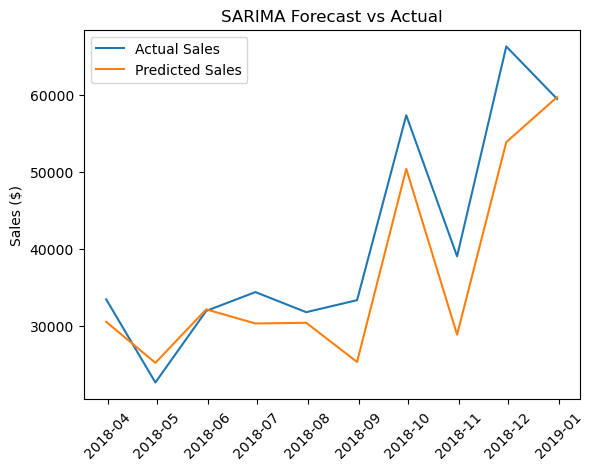

In [96]:
plt.plot(sarima_test.index, sarima_test, label='Actual Sales')
plt.plot(sarima_test.index, sarima_pred, label='Predicted Sales')
plt.ylabel('Sales ($)')
plt.title('SARIMA Forecast vs Actual')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [94]:
rmse = root_mean_squared_error(sarima_test, sarima_pred)
mae = mean_absolute_error(sarima_test, sarima_pred)
mape = (abs((sarima_test - sarima_pred) / sarima_test)).mean() * 100

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")

RMSE: 6361.64
MAE: 4896.66
MAPE: 11.82%


This SARIMA model captures both trend and yearly seasonality in the monthly resampled sales data. The ARIMA(1,1,0) component models month-over-month changes based on the immediate previous month (AR[1]), while the (0,1,0)[12] seasonal component applies a 12-month seasonal differencing to remove annual cycles. No moving average terms were found beneficial. The model forecasts sales with a MAPE of 11.82%, indicating strong predictive accuracy with average errors of ~$4,900. This result shows that recent monthly changes and annual seasonality are key drivers of sales in this dataset.

### SARIMAX Model

In [98]:
X_train = sarimax_train.drop(columns='Sales')
y_train = sarimax_train['Sales']

X_test = sarimax_test.drop(columns='Sales')
y_test = sarimax_test['Sales']

In [100]:
model_sarimax = pm.auto_arima(
    y_train,
    exogenous=X_train,
    seasonal=True,
    m=12,
    d=1,
    D=1,
    stepwise=True,
    suppress_warnings=True,
    trace=True
) 

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=inf, Time=0.39 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=308.710, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=311.479, Time=0.03 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=312.504, Time=0.05 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=310.267, Time=0.09 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=310.279, Time=0.02 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=312.279, Time=0.04 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=309.723, Time=0.02 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=310.775, Time=0.03 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=312.435, Time=0.04 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=310.623, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,1,0)[12]          
Total fit time: 0.735 seconds


For the SARIMAX model, we have both AR(0) and MA(0) non-seasonal terms which indicate there are no significant autocorrelation or past error patterns strong enough to make predictions. Instead, we model the month-to-month change in sales directly and let the exogenous variables explain most of the signal.

The seasonal part also does not include AR or MA terms, but does use annual differencing to eliminate repeating yearly cycles.

In [102]:
model_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   28
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -153.355
Date:                            Tue, 10 Jun 2025   AIC                            308.710
Time:                                    16:44:29   BIC                            309.418
Sample:                                01-31-2016   HQIC                           308.703
                                     - 04-30-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.012e+07   1.95e+07      2.056      0.040    1.88e+06    7.84e+07
===================================================================================
Ljung-Box (L1) (Q):                   3.98   Jarque-Bera (JB):                 0.99
Prob(Q):                              0.05   Prob(JB):                         0.61
Heteroskedasticity (H):               0.75   Skew:                             0.36
Prob(H) (two-sided):                  0.76   Kurtosis:                         1.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [104]:
sarimax_pred = model_sarimax.predict(n_periods=len(sarimax_test))

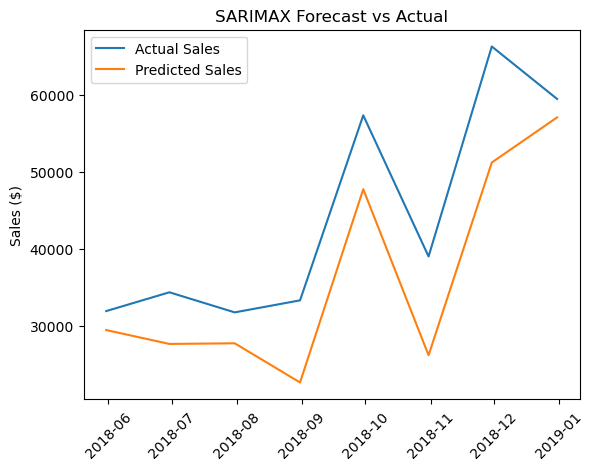

In [106]:
plt.plot(sarimax_test.index, sarimax_test['Sales'], label='Actual Sales')
plt.plot(sarimax_test.index, sarimax_pred, label='Predicted Sales')
plt.ylabel('Sales ($)')
plt.title('SARIMAX Forecast vs Actual')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [110]:
actual_sales = sarimax_test['Sales']
predicted_sales = sarimax_pred

rmse = root_mean_squared_error(actual_sales, predicted_sales)
mae = mean_absolute_error(actual_sales, predicted_sales)
mape = (abs((actual_sales - predicted_sales) / actual_sales)).mean() * 100

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")

RMSE: 9150.27
MAE: 7963.83
MAPE: 18.51%


Compared to the SARIMA model, SARIMAX underperformed. It seems that the included exogenous variables may not have been helpful and could have introduced noise or multicollinearity, making it difficult for the model to learn. The SARIMAX model had average errors of ~$8,000.

### LSTM Model

(train_lstm pid=59760) Epoch 0: loss = 0.137683


(train_lstm pid=59760) C:\Users\justi\anaconda3\Lib\site-packages\ray\train\_internal\session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_lstm pid=59760)   _log_deprecation_warning(
(train_lstm pid=59760) C:\Users\justi\anaconda3\Lib\site-packages\ray\tune\trainable\trainable_fn_utils.py:41: RayDeprecationWarning: The `Checkpoint` class should be imported from `ray.tune` when passing it to `ray.tune.report` in a Tune function. Please update your imports. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
(train_lstm pid=59760)   _log_deprecation_warning(
(train_lstm pid=59760) Checkpoint successfully created at: Checkpoi

(train_lstm pid=59760) Epoch 10: loss = 0.035809


(train_lstm pid=59884) C:\Users\justi\anaconda3\Lib\site-packages\ray\train\_internal\session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454 [repeated 7x across cluster]
(train_lstm pid=59884)   _log_deprecation_warning( [repeated 14x across cluster]
(train_lstm pid=59884) C:\Users\justi\anaconda3\Lib\site-packages\ray\tune\trainable\trainable_fn_utils.py:41: RayDeprecationWarning: The `Checkpoint` class should be imported from `ray.tune` when passing it to `ray.tune.report` in a Tune function. Please update your imports. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0 [repeated 7x across cluster]
(train_lstm pid=46896) Checkpo

(train_lstm pid=46896) Epoch 20: loss = 0.024915 [repeated 23x across cluster]


(train_lstm pid=59884) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00007_7_2025-05-14_23-22-59/checkpoint_000005) [repeated 39x across cluster]


(train_lstm pid=59884) Epoch 50: loss = 0.020813 [repeated 39x across cluster]


(train_lstm pid=59760) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00000_0_2025-05-14_23-22-59/checkpoint_000016) [repeated 33x across cluster]


(train_lstm pid=59760) Epoch 160: loss = 0.002216 [repeated 33x across cluster]
(train_lstm pid=59884) Epoch 130: loss = 0.002984 [repeated 32x across cluster]


(train_lstm pid=46896) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00006_6_2025-05-14_23-22-59/checkpoint_000015) [repeated 33x across cluster]


(train_lstm pid=15376) Epoch 190: loss = 0.001694 [repeated 40x across cluster]


(train_lstm pid=52072) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00002_2_2025-05-14_23-22-59/checkpoint_000021) [repeated 39x across cluster]
(train_lstm pid=59760) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00000_0_2025-05-14_23-22-59/checkpoint_000032) [repeated 41x across cluster]


(train_lstm pid=59760) Epoch 320: loss = 0.000502 [repeated 41x across cluster]
(train_lstm pid=57756) Epoch 300: loss = 0.000877 [repeated 37x across cluster]


(train_lstm pid=52072) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00002_2_2025-05-14_23-22-59/checkpoint_000031) [repeated 38x across cluster]


(train_lstm pid=52072) Epoch 350: loss = 0.000596 [repeated 33x across cluster]


(train_lstm pid=59760) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00000_0_2025-05-14_23-22-59/checkpoint_000043) [repeated 35x across cluster]


(train_lstm pid=58772) Epoch 390: loss = 0.000557 [repeated 38x across cluster]


(train_lstm pid=59884) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00007_7_2025-05-14_23-22-59/checkpoint_000037) [repeated 37x across cluster]


(train_lstm pid=46896) 
(train_lstm pid=52072) Epoch 440: loss = 0.000641 [repeated 34x across cluster]


(train_lstm pid=59760) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00000_0_2025-05-14_23-22-59/checkpoint_000053) [repeated 35x across cluster]
(train_lstm pid=59884) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00007_7_2025-05-14_23-22-59/checkpoint_000045) [repeated 32x across cluster]


(train_lstm pid=59884) Epoch 450: loss = 0.000486 [repeated 35x across cluster]


(train_lstm pid=59884) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00007_7_2025-05-14_23-22-59/checkpoint_000050) [repeated 41x across cluster]


(train_lstm pid=59884) Epoch 500: loss = 0.000383 [repeated 41x across cluster]


(train_lstm pid=52072) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00002_2_2025-05-14_23-22-59/checkpoint_000059) [repeated 42x across cluster]


(train_lstm pid=52072) Epoch 590: loss = 0.000523 [repeated 42x across cluster]


(train_lstm pid=52072) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00002_2_2025-05-14_23-22-59/checkpoint_000065) [repeated 46x across cluster]


(train_lstm pid=52072) Epoch 650: loss = 0.000321 [repeated 46x across cluster]


(train_lstm pid=58772) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00003_3_2025-05-14_23-22-59/checkpoint_000069) [repeated 45x across cluster]


(train_lstm pid=58772) Epoch 690: loss = 0.000597 [repeated 45x across cluster]


(train_lstm pid=58772) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00003_3_2025-05-14_23-22-59/checkpoint_000075) [repeated 42x across cluster]


(train_lstm pid=58772) Epoch 750: loss = 0.000344 [repeated 42x across cluster]


(train_lstm pid=59884) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00007_7_2025-05-14_23-22-59/checkpoint_000079) [repeated 37x across cluster]


(train_lstm pid=59884) Epoch 790: loss = 0.000433 [repeated 37x across cluster]


(train_lstm pid=58096) C:\Users\justi\anaconda3\Lib\site-packages\ray\train\_internal\session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_lstm pid=58096)   _log_deprecation_warning(
(train_lstm pid=58096) C:\Users\justi\anaconda3\Lib\site-packages\ray\tune\trainable\trainable_fn_utils.py:41: RayDeprecationWarning: The `Checkpoint` class should be imported from `ray.tune` when passing it to `ray.tune.report` in a Tune function. Please update your imports. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
(train_lstm pid=58096)   _log_deprecation_warning(
(train_lstm pid=58096) Checkpoint successfully created at: Checkpoi

(train_lstm pid=58096) Epoch 0: loss = 0.137683
(train_lstm pid=59492) Epoch 0: loss = 0.137683


(train_lstm pid=57984) C:\Users\justi\anaconda3\Lib\site-packages\ray\train\_internal\session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454 [repeated 2x across cluster]
(train_lstm pid=57984)   _log_deprecation_warning( [repeated 4x across cluster]
(train_lstm pid=57984) C:\Users\justi\anaconda3\Lib\site-packages\ray\tune\trainable\trainable_fn_utils.py:41: RayDeprecationWarning: The `Checkpoint` class should be imported from `ray.tune` when passing it to `ray.tune.report` in a Tune function. Please update your imports. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0 [repeated 2x across cluster]
(train_lstm pid=59492) Checkpoi

(train_lstm pid=58096) Epoch 70: loss = 0.013584 [repeated 19x across cluster]


(train_lstm pid=59428) C:\Users\justi\anaconda3\Lib\site-packages\ray\train\_internal\session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454 [repeated 5x across cluster]
(train_lstm pid=59428)   _log_deprecation_warning( [repeated 10x across cluster]
(train_lstm pid=59428) C:\Users\justi\anaconda3\Lib\site-packages\ray\tune\trainable\trainable_fn_utils.py:41: RayDeprecationWarning: The `Checkpoint` class should be imported from `ray.tune` when passing it to `ray.tune.report` in a Tune function. Please update your imports. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0 [repeated 5x across cluster]
(train_lstm pid=41456) Checkpo

(train_lstm pid=41456) Epoch 20: loss = 0.024915 [repeated 30x across cluster]
(train_lstm pid=38112) Epoch 80: loss = 0.011089 [repeated 44x across cluster]


(train_lstm pid=38112) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00015_15_2025-05-14_23-22-59/checkpoint_000008) [repeated 44x across cluster]


(train_lstm pid=59492) Epoch 230: loss = 0.000961 [repeated 42x across cluster]


(train_lstm pid=59492) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00009_9_2025-05-14_23-22-59/checkpoint_000023) [repeated 42x across cluster]
(train_lstm pid=57984) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00010_10_2025-05-14_23-22-59/checkpoint_000028) [repeated 46x across cluster]


(train_lstm pid=57984) Epoch 280: loss = 0.000555 [repeated 46x across cluster]


(train_lstm pid=59428) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00014_14_2025-05-14_23-22-59/checkpoint_000023) [repeated 43x across cluster]


(train_lstm pid=59428) Epoch 230: loss = 0.000961 [repeated 43x across cluster]


(train_lstm pid=59492) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00009_9_2025-05-14_23-22-59/checkpoint_000039) [repeated 41x across cluster]


(train_lstm pid=59492) Epoch 390: loss = 0.000557 [repeated 41x across cluster]
(train_lstm pid=32456) Epoch 350: loss = 0.000596 [repeated 45x across cluster]


(train_lstm pid=32456) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00013_13_2025-05-14_23-22-59/checkpoint_000035) [repeated 45x across cluster]
(train_lstm pid=59428) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00014_14_2025-05-14_23-22-59/checkpoint_000039) [repeated 43x across cluster]


(train_lstm pid=59428) Epoch 390: loss = 0.000557 [repeated 43x across cluster]


(train_lstm pid=60152) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00011_11_2025-05-14_23-22-59/checkpoint_000046) [repeated 42x across cluster]


(train_lstm pid=60152) Epoch 460: loss = 0.000471 [repeated 42x across cluster]
(train_lstm pid=58096) Epoch 610: loss = 0.000331 [repeated 44x across cluster]


(train_lstm pid=58096) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00008_8_2025-05-14_23-22-59/checkpoint_000061) [repeated 44x across cluster]


(train_lstm pid=38112) Epoch 560: loss = 0.000653 [repeated 41x across cluster]


(train_lstm pid=38112) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00015_15_2025-05-14_23-22-59/checkpoint_000056) [repeated 41x across cluster]


(train_lstm pid=59428) Epoch 600: loss = 0.000395 [repeated 44x across cluster]


(train_lstm pid=59428) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00014_14_2025-05-14_23-22-59/checkpoint_000060) [repeated 44x across cluster]
(train_lstm pid=57984) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00010_10_2025-05-14_23-22-59/checkpoint_000077) [repeated 45x across cluster]


(train_lstm pid=57984) Epoch 770: loss = 0.000422 [repeated 45x across cluster]


(train_lstm pid=59428) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00014_14_2025-05-14_23-22-59/checkpoint_000071) [repeated 34x across cluster]


(train_lstm pid=59428) Epoch 710: loss = 0.000455 [repeated 34x across cluster]


(train_lstm pid=59428) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00014_14_2025-05-14_23-22-59/checkpoint_000077) [repeated 29x across cluster]


(train_lstm pid=59428) Epoch 770: loss = 0.000422 [repeated 29x across cluster]


(train_lstm pid=58024) C:\Users\justi\anaconda3\Lib\site-packages\ray\train\_internal\session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_lstm pid=58024)   _log_deprecation_warning(
(train_lstm pid=58024) C:\Users\justi\anaconda3\Lib\site-packages\ray\tune\trainable\trainable_fn_utils.py:41: RayDeprecationWarning: The `Checkpoint` class should be imported from `ray.tune` when passing it to `ray.tune.report` in a Tune function. Please update your imports. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
(train_lstm pid=58024)   _log_deprecation_warning(
(train_lstm pid=59428) Checkpoint successfully created at: Checkpoi

(train_lstm pid=58024) Epoch 0: loss = 0.137683 [repeated 7x across cluster]


(train_lstm pid=58876) C:\Users\justi\anaconda3\Lib\site-packages\ray\train\_internal\session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454 [repeated 2x across cluster]
(train_lstm pid=58876)   _log_deprecation_warning( [repeated 4x across cluster]
(train_lstm pid=58876) C:\Users\justi\anaconda3\Lib\site-packages\ray\tune\trainable\trainable_fn_utils.py:41: RayDeprecationWarning: The `Checkpoint` class should be imported from `ray.tune` when passing it to `ray.tune.report` in a Tune function. Please update your imports. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0 [repeated 2x across cluster]
(train_lstm pid=58876) Checkpoi

(train_lstm pid=58876) Epoch 50: loss = 0.020813 [repeated 18x across cluster]
(train_lstm pid=58164) Epoch 30: loss = 0.023607 [repeated 30x across cluster]


(train_lstm pid=45964) C:\Users\justi\anaconda3\Lib\site-packages\ray\train\_internal\session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454 [repeated 4x across cluster]
(train_lstm pid=45964)   _log_deprecation_warning( [repeated 8x across cluster]
(train_lstm pid=45964) C:\Users\justi\anaconda3\Lib\site-packages\ray\tune\trainable\trainable_fn_utils.py:41: RayDeprecationWarning: The `Checkpoint` class should be imported from `ray.tune` when passing it to `ray.tune.report` in a Tune function. Please update your imports. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0 [repeated 4x across cluster]
(train_lstm pid=52460) Checkpoi

(train_lstm pid=58620) Epoch 80: loss = 0.011089 [repeated 39x across cluster]


(train_lstm pid=58876) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00017_17_2025-05-14_23-22-59/checkpoint_000017) [repeated 39x across cluster]
(train_lstm pid=58380) C:\Users\justi\anaconda3\Lib\site-packages\ray\train\_internal\session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_lstm pid=58380)   _log_deprecation_warning(
(train_lstm pid=58380) C:\Users\justi\anaconda3\Lib\site-packages\ray\tune\trainable\trainable_fn_utils.py:41: RayDeprecationWarning: The `Checkpoint` class should be imported from `ray.tune` when passing it to `ray.tune.report` in a Tune function. Please update your imports. See this issue for more context and migration options: https://github.com/ray-project/ray/issue

(train_lstm pid=52460) Epoch 230: loss = 0.000961 [repeated 41x across cluster]


(train_lstm pid=58164) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00019_19_2025-05-14_23-22-59/checkpoint_000014) [repeated 41x across cluster]


(train_lstm pid=45964) Epoch 180: loss = 0.001096 [repeated 43x across cluster]


(train_lstm pid=44468) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00022_22_2025-05-14_23-22-59/checkpoint_000019) [repeated 43x across cluster]


(train_lstm pid=58876) Epoch 330: loss = 0.000507 [repeated 42x across cluster]


(train_lstm pid=58876) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00017_17_2025-05-14_23-22-59/checkpoint_000033) [repeated 41x across cluster]
(train_lstm pid=58164) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00019_19_2025-05-14_23-22-59/checkpoint_000030) [repeated 44x across cluster]


(train_lstm pid=58164) Epoch 300: loss = 0.000877 [repeated 44x across cluster]


(train_lstm pid=52460) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00018_18_2025-05-14_23-22-59/checkpoint_000045) [repeated 44x across cluster]


(train_lstm pid=52460) Epoch 450: loss = 0.000486 [repeated 44x across cluster]


(train_lstm pid=58164) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00019_19_2025-05-14_23-22-59/checkpoint_000040) [repeated 39x across cluster]


(train_lstm pid=58164) Epoch 400: loss = 0.000523 [repeated 39x across cluster]
(train_lstm pid=45964) Epoch 440: loss = 0.000641 [repeated 42x across cluster]


(train_lstm pid=45964) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00021_21_2025-05-14_23-22-59/checkpoint_000044) [repeated 42x across cluster]
(train_lstm pid=58164) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00019_19_2025-05-14_23-22-59/checkpoint_000050) [repeated 42x across cluster]


(train_lstm pid=58164) Epoch 500: loss = 0.000383 [repeated 42x across cluster]


(train_lstm pid=58876) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00017_17_2025-05-14_23-22-59/checkpoint_000065) [repeated 43x across cluster]


(train_lstm pid=58876) Epoch 650: loss = 0.000321 [repeated 43x across cluster]


(train_lstm pid=58164) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00019_19_2025-05-14_23-22-59/checkpoint_000061) [repeated 45x across cluster]


(train_lstm pid=58164) Epoch 610: loss = 0.000331 [repeated 45x across cluster]


(train_lstm pid=44468) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00022_22_2025-05-14_23-22-59/checkpoint_000068) [repeated 45x across cluster]


(train_lstm pid=58024) Epoch 780: loss = 0.000374 [repeated 46x across cluster]


(train_lstm pid=58164) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00019_19_2025-05-14_23-22-59/checkpoint_000072) [repeated 35x across cluster]


(train_lstm pid=44468) Epoch 740: loss = 0.000545 [repeated 37x across cluster]


(train_lstm pid=58380) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00023_23_2025-05-14_23-22-59/checkpoint_000068) [repeated 32x across cluster]


(train_lstm pid=58620) Epoch 790: loss = 0.000433 [repeated 30x across cluster]


(train_lstm pid=58380) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00023_23_2025-05-14_23-22-59/checkpoint_000075) [repeated 11x across cluster]


(train_lstm pid=58380) Epoch 750: loss = 0.000344 [repeated 10x across cluster]


(train_lstm pid=59544) C:\Users\justi\anaconda3\Lib\site-packages\ray\train\_internal\session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_lstm pid=59544)   _log_deprecation_warning(
(train_lstm pid=59544) C:\Users\justi\anaconda3\Lib\site-packages\ray\tune\trainable\trainable_fn_utils.py:41: RayDeprecationWarning: The `Checkpoint` class should be imported from `ray.tune` when passing it to `ray.tune.report` in a Tune function. Please update your imports. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
(train_lstm pid=59544)   _log_deprecation_warning(
(train_lstm pid=59544) Checkpoint successfully created at: Checkpoi

(train_lstm pid=59544) Epoch 0: loss = 0.137683 [repeated 5x across cluster]


(train_lstm pid=60328) C:\Users\justi\anaconda3\Lib\site-packages\ray\train\_internal\session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454 [repeated 6x across cluster]
(train_lstm pid=60328)   _log_deprecation_warning( [repeated 12x across cluster]
(train_lstm pid=60328) C:\Users\justi\anaconda3\Lib\site-packages\ray\tune\trainable\trainable_fn_utils.py:41: RayDeprecationWarning: The `Checkpoint` class should be imported from `ray.tune` when passing it to `ray.tune.report` in a Tune function. Please update your imports. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0 [repeated 6x across cluster]
(train_lstm pid=59544) Checkpo

(train_lstm pid=59544) Epoch 60: loss = 0.019696 [repeated 34x across cluster]


(train_lstm pid=59168) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00028_28_2025-05-14_23-22-59/checkpoint_000009) [repeated 38x across cluster]


(train_lstm pid=59168) Epoch 90: loss = 0.006982 [repeated 38x across cluster]


(train_lstm pid=58060) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00029_29_2025-05-14_23-22-59/checkpoint_000015) [repeated 38x across cluster]


(train_lstm pid=59544) Epoch 170: loss = 0.001462 [repeated 39x across cluster]


(train_lstm pid=59744) C:\Users\justi\anaconda3\Lib\site-packages\ray\train\_internal\session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_lstm pid=59744)   _log_deprecation_warning(
(train_lstm pid=59744) C:\Users\justi\anaconda3\Lib\site-packages\ray\tune\trainable\trainable_fn_utils.py:41: RayDeprecationWarning: The `Checkpoint` class should be imported from `ray.tune` when passing it to `ray.tune.report` in a Tune function. Please update your imports. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
(train_lstm pid=59744)   _log_deprecation_warning(
(train_lstm pid=59744) Checkpoint successfully created at: Checkpoi

(train_lstm pid=50492) Epoch 210: loss = 0.000853 [repeated 45x across cluster]


(train_lstm pid=59040) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00026_26_2025-05-14_23-22-59/checkpoint_000028) [repeated 43x across cluster]


(train_lstm pid=59744) Epoch 100: loss = 0.006836 [repeated 45x across cluster]


(train_lstm pid=60328) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00030_30_2025-05-14_23-22-59/checkpoint_000029) [repeated 44x across cluster]


(train_lstm pid=59040) Epoch 340: loss = 0.000509 [repeated 43x across cluster]


(train_lstm pid=4044) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00024_24_2025-05-14_23-22-59/checkpoint_000038) [repeated 41x across cluster]


(train_lstm pid=50492) Epoch 370: loss = 0.000476 [repeated 43x across cluster]


(train_lstm pid=4044) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00024_24_2025-05-14_23-22-59/checkpoint_000043) [repeated 45x across cluster]


(train_lstm pid=59544) Epoch 440: loss = 0.000641 [repeated 41x across cluster]


(train_lstm pid=59544) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00025_25_2025-05-14_23-22-59/checkpoint_000049) [repeated 42x across cluster]


(train_lstm pid=4044) Epoch 490: loss = 0.000524 [repeated 45x across cluster]


(train_lstm pid=60328) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00030_30_2025-05-14_23-22-59/checkpoint_000051) [repeated 44x across cluster]


(train_lstm pid=59544) Epoch 550: loss = 0.000429 [repeated 43x across cluster]


(train_lstm pid=59544) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00025_25_2025-05-14_23-22-59/checkpoint_000060) [repeated 44x across cluster]


(train_lstm pid=4044) Epoch 600: loss = 0.000395 [repeated 46x across cluster]


(train_lstm pid=4044) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00024_24_2025-05-14_23-22-59/checkpoint_000065) [repeated 46x across cluster]


(train_lstm pid=59544) Epoch 660: loss = 0.000340 [repeated 43x across cluster]


(train_lstm pid=58060) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00029_29_2025-05-14_23-22-59/checkpoint_000070) [repeated 47x across cluster]


(train_lstm pid=59040) Epoch 720: loss = 0.000397 [repeated 47x across cluster]


(train_lstm pid=59040) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00026_26_2025-05-14_23-22-59/checkpoint_000077) [repeated 43x across cluster]


(train_lstm pid=58060) Epoch 760: loss = 0.000368 [repeated 44x across cluster]


(train_lstm pid=59744) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00031_31_2025-05-14_23-22-59/checkpoint_000064) [repeated 32x across cluster]


(train_lstm pid=59744) Epoch 640: loss = 0.000374 [repeated 28x across cluster]


(train_lstm pid=59744) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00031_31_2025-05-14_23-22-59/checkpoint_000071) [repeated 7x across cluster]


(train_lstm pid=59744) Epoch 710: loss = 0.000455 [repeated 7x across cluster]


(train_lstm pid=59744) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00031_31_2025-05-14_23-22-59/checkpoint_000077) [repeated 6x across cluster]


(train_lstm pid=59744) Epoch 780: loss = 0.000374 [repeated 7x across cluster]


(train_lstm pid=59640) C:\Users\justi\anaconda3\Lib\site-packages\ray\train\_internal\session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_lstm pid=59640)   _log_deprecation_warning(
(train_lstm pid=59640) C:\Users\justi\anaconda3\Lib\site-packages\ray\tune\trainable\trainable_fn_utils.py:41: RayDeprecationWarning: The `Checkpoint` class should be imported from `ray.tune` when passing it to `ray.tune.report` in a Tune function. Please update your imports. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
(train_lstm pid=59640)   _log_deprecation_warning(
(train_lstm pid=59640) Checkpoint successfully created at: Checkpoi

(train_lstm pid=59640) Epoch 0: loss = 0.137683 [repeated 2x across cluster]


(train_lstm pid=58032) C:\Users\justi\anaconda3\Lib\site-packages\ray\train\_internal\session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454 [repeated 6x across cluster]
(train_lstm pid=58032)   _log_deprecation_warning( [repeated 12x across cluster]
(train_lstm pid=58032) C:\Users\justi\anaconda3\Lib\site-packages\ray\tune\trainable\trainable_fn_utils.py:41: RayDeprecationWarning: The `Checkpoint` class should be imported from `ray.tune` when passing it to `ray.tune.report` in a Tune function. Please update your imports. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0 [repeated 6x across cluster]
(train_lstm pid=59640) Checkpo

(train_lstm pid=59640) Epoch 60: loss = 0.019696 [repeated 32x across cluster]


(train_lstm pid=56296) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00036_36_2025-05-14_23-22-59/checkpoint_000009) [repeated 40x across cluster]


(train_lstm pid=56296) Epoch 90: loss = 0.006982 [repeated 40x across cluster]


(train_lstm pid=59692) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00032_32_2025-05-14_23-22-59/checkpoint_000016) [repeated 39x across cluster]


(train_lstm pid=56744) Epoch 170: loss = 0.001462 [repeated 40x across cluster]


(train_lstm pid=8788) C:\Users\justi\anaconda3\Lib\site-packages\ray\train\_internal\session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_lstm pid=8788)   _log_deprecation_warning(
(train_lstm pid=8788) C:\Users\justi\anaconda3\Lib\site-packages\ray\tune\trainable\trainable_fn_utils.py:41: RayDeprecationWarning: The `Checkpoint` class should be imported from `ray.tune` when passing it to `ray.tune.report` in a Tune function. Please update your imports. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
(train_lstm pid=8788)   _log_deprecation_warning(
(train_lstm pid=59640) Checkpoint successfully created at: Checkpoint(f

(train_lstm pid=59640) Epoch 230: loss = 0.000961 [repeated 38x across cluster]


(train_lstm pid=59752) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00035_35_2025-05-14_23-22-59/checkpoint_000027) [repeated 43x across cluster]


(train_lstm pid=59752) Epoch 270: loss = 0.000744 [repeated 43x across cluster]


(train_lstm pid=56744) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00033_33_2025-05-14_23-22-59/checkpoint_000033) [repeated 43x across cluster]


(train_lstm pid=58044) Epoch 310: loss = 0.000959 [repeated 44x across cluster]


(train_lstm pid=58032) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00038_38_2025-05-14_23-22-59/checkpoint_000034) [repeated 42x across cluster]


(train_lstm pid=58032) Epoch 340: loss = 0.000509 [repeated 41x across cluster]


(train_lstm pid=8788) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00039_39_2025-05-14_23-22-59/checkpoint_000022) [repeated 43x across cluster]


(train_lstm pid=8788) Epoch 220: loss = 0.000649 [repeated 43x across cluster]


(train_lstm pid=59692) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00032_32_2025-05-14_23-22-59/checkpoint_000048) [repeated 42x across cluster]


(train_lstm pid=59692) Epoch 480: loss = 0.000585 [repeated 42x across cluster]


(train_lstm pid=59752) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00035_35_2025-05-14_23-22-59/checkpoint_000053) [repeated 43x across cluster]


(train_lstm pid=59752) Epoch 530: loss = 0.000318 [repeated 43x across cluster]


(train_lstm pid=56744) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00033_33_2025-05-14_23-22-59/checkpoint_000060) [repeated 43x across cluster]


(train_lstm pid=56744) Epoch 600: loss = 0.000395 [repeated 43x across cluster]
(train_lstm pid=58044) Epoch 630: loss = 0.000408 [repeated 43x across cluster]


(train_lstm pid=58032) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00038_38_2025-05-14_23-22-59/checkpoint_000061) [repeated 44x across cluster]
(train_lstm pid=59640) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00034_34_2025-05-14_23-22-59/checkpoint_000071) [repeated 41x across cluster]


(train_lstm pid=59692) Epoch 700: loss = 0.000551 [repeated 43x across cluster]


(train_lstm pid=8788) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00039_39_2025-05-14_23-22-59/checkpoint_000054) [repeated 43x across cluster]


(train_lstm pid=56744) Epoch 760: loss = 0.000368 [repeated 43x across cluster]


(raylet) Traceback (most recent call last):
(raylet)   File "C:\Users\justi\anaconda3\Lib\site-packages\ray\_private\workers\default_worker.py", line 8, in <module>
(raylet)     import ray
(raylet)     _configure_system()
(raylet)   File "C:\Users\justi\anaconda3\Lib\site-packages\ray\__init__.py", line 70, in _configure_system
(raylet)     import ctypes
(raylet)     from _ctypes import Union, Structure, Array
(raylet) ImportError: DLL load failed while importing _ctypes: The handle is invalid.
(train_lstm pid=56296) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00036_36_2025-05-14_23-22-59/checkpoint_000078) [repeated 37x across cluster]


(train_lstm pid=58044) Epoch 790: loss = 0.000433 [repeated 38x across cluster]


(raylet)   File "C:\Users\justi\anaconda3\Lib\ctypes\__init__.py", line 8, in <module> [repeated 2x across cluster]
(train_lstm pid=8788) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00039_39_2025-05-14_23-22-59/checkpoint_000066) [repeated 12x across cluster]


(train_lstm pid=8788) Epoch 660: loss = 0.000340 [repeated 10x across cluster]
(train_lstm pid=8788) Epoch 730: loss = 0.000350 [repeated 7x across cluster]


(train_lstm pid=8788) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00039_39_2025-05-14_23-22-59/checkpoint_000073) [repeated 7x across cluster]
(train_lstm pid=51364) C:\Users\justi\anaconda3\Lib\site-packages\ray\train\_internal\session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_lstm pid=51364)   _log_deprecation_warning(
(train_lstm pid=51364) C:\Users\justi\anaconda3\Lib\site-packages\ray\tune\trainable\trainable_fn_utils.py:41: RayDeprecationWarning: The `Checkpoint` class should be imported from `ray.tune` when passing it to `ray.tune.report` in a Tune function. Please update your imports. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/

(train_lstm pid=51364) Epoch 0: loss = 0.137683 [repeated 7x across cluster]


(train_lstm pid=60480) C:\Users\justi\anaconda3\Lib\site-packages\ray\train\_internal\session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454 [repeated 6x across cluster]
(train_lstm pid=60480)   _log_deprecation_warning( [repeated 12x across cluster]
(train_lstm pid=60480) C:\Users\justi\anaconda3\Lib\site-packages\ray\tune\trainable\trainable_fn_utils.py:41: RayDeprecationWarning: The `Checkpoint` class should be imported from `ray.tune` when passing it to `ray.tune.report` in a Tune function. Please update your imports. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0 [repeated 6x across cluster]
(train_lstm pid=57972) Checkpo

(train_lstm pid=57972) Epoch 40: loss = 0.023920 [repeated 27x across cluster]


(train_lstm pid=58412) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00041_41_2025-05-14_23-22-59/checkpoint_000010) [repeated 39x across cluster]


(train_lstm pid=58412) Epoch 100: loss = 0.006836 [repeated 39x across cluster]


(train_lstm pid=51364) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00040_40_2025-05-14_23-22-59/checkpoint_000017) [repeated 41x across cluster]


(train_lstm pid=51364) Epoch 170: loss = 0.001462 [repeated 41x across cluster]


(raylet) [2025-05-14 23:33:42,924 E 39848 59404] (raylet.exe) worker_pool.cc:581: Some workers of the worker process(59480) have not registered within the timeout. The process is dead, probably it crashed during start.
(train_lstm pid=58412) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00041_41_2025-05-14_23-22-59/checkpoint_000021) [repeated 36x across cluster]


(train_lstm pid=58412) Epoch 210: loss = 0.000853 [repeated 36x across cluster]


(train_lstm pid=54548) C:\Users\justi\anaconda3\Lib\site-packages\ray\train\_internal\session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_lstm pid=54548)   _log_deprecation_warning(
(train_lstm pid=54548) C:\Users\justi\anaconda3\Lib\site-packages\ray\tune\trainable\trainable_fn_utils.py:41: RayDeprecationWarning: The `Checkpoint` class should be imported from `ray.tune` when passing it to `ray.tune.report` in a Tune function. Please update your imports. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
(train_lstm pid=54548)   _log_deprecation_warning(
(train_lstm pid=51364) Checkpoint successfully created at: Checkpoi

(train_lstm pid=51364) Epoch 280: loss = 0.000555 [repeated 42x across cluster]


(train_lstm pid=36080) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00042_42_2025-05-14_23-22-59/checkpoint_000032) [repeated 43x across cluster]


(train_lstm pid=60480) Epoch 280: loss = 0.000555 [repeated 44x across cluster]


(train_lstm pid=61264) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00043_43_2025-05-14_23-22-59/checkpoint_000034) [repeated 42x across cluster]


(train_lstm pid=61264) Epoch 340: loss = 0.000509 [repeated 41x across cluster]


(train_lstm pid=58412) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00041_41_2025-05-14_23-22-59/checkpoint_000043) [repeated 43x across cluster]


(train_lstm pid=58412) Epoch 430: loss = 0.000807 [repeated 43x across cluster]


(train_lstm pid=54548) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00047_47_2025-05-14_23-22-59/checkpoint_000022) [repeated 43x across cluster]


(train_lstm pid=51364) Epoch 500: loss = 0.000383 [repeated 45x across cluster]


(train_lstm pid=36080) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00042_42_2025-05-14_23-22-59/checkpoint_000054) [repeated 45x across cluster]


(train_lstm pid=36080) Epoch 540: loss = 0.000524 [repeated 43x across cluster]


(train_lstm pid=54548) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00047_47_2025-05-14_23-22-59/checkpoint_000033) [repeated 43x across cluster]


(train_lstm pid=54548) Epoch 330: loss = 0.000507 [repeated 43x across cluster]


(train_lstm pid=60480) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00046_46_2025-05-14_23-22-59/checkpoint_000060) [repeated 44x across cluster]


(train_lstm pid=60480) Epoch 600: loss = 0.000395 [repeated 44x across cluster]


(train_lstm pid=61264) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00043_43_2025-05-14_23-22-59/checkpoint_000066) [repeated 42x across cluster]


(train_lstm pid=61264) Epoch 660: loss = 0.000340 [repeated 42x across cluster]


(train_lstm pid=51364) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00040_40_2025-05-14_23-22-59/checkpoint_000077) [repeated 43x across cluster]


(train_lstm pid=51364) Epoch 770: loss = 0.000422 [repeated 43x across cluster]
(train_lstm pid=60480) Epoch 770: loss = 0.000422 [repeated 37x across cluster]


(train_lstm pid=61264) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00043_43_2025-05-14_23-22-59/checkpoint_000078) [repeated 37x across cluster]


(train_lstm pid=54548) Epoch 610: loss = 0.000331 [repeated 11x across cluster]


(train_lstm pid=54548) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00047_47_2025-05-14_23-22-59/checkpoint_000062) [repeated 12x across cluster]


(train_lstm pid=54548) Epoch 660: loss = 0.000340 [repeated 5x across cluster]


(train_lstm pid=54548) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00047_47_2025-05-14_23-22-59/checkpoint_000067) [repeated 5x across cluster]


(train_lstm pid=54548) Epoch 720: loss = 0.000397 [repeated 6x across cluster]


(train_lstm pid=54548) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00047_47_2025-05-14_23-22-59/checkpoint_000074) [repeated 7x across cluster]


(train_lstm pid=54548) Epoch 790: loss = 0.000433 [repeated 7x across cluster]


(train_lstm pid=56996) C:\Users\justi\anaconda3\Lib\site-packages\ray\train\_internal\session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_lstm pid=56996)   _log_deprecation_warning(
(train_lstm pid=56996) C:\Users\justi\anaconda3\Lib\site-packages\ray\tune\trainable\trainable_fn_utils.py:41: RayDeprecationWarning: The `Checkpoint` class should be imported from `ray.tune` when passing it to `ray.tune.report` in a Tune function. Please update your imports. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
(train_lstm pid=56996)   _log_deprecation_warning(
(train_lstm pid=56996) Checkpoint successfully created at: Checkpoi

(train_lstm pid=56996) Epoch 0: loss = 0.137683
(train_lstm pid=53032) Epoch 0: loss = 0.137683


(train_lstm pid=42588) C:\Users\justi\anaconda3\Lib\site-packages\ray\train\_internal\session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454 [repeated 6x across cluster]
(train_lstm pid=42588)   _log_deprecation_warning( [repeated 12x across cluster]
(train_lstm pid=42588) C:\Users\justi\anaconda3\Lib\site-packages\ray\tune\trainable\trainable_fn_utils.py:41: RayDeprecationWarning: The `Checkpoint` class should be imported from `ray.tune` when passing it to `ray.tune.report` in a Tune function. Please update your imports. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0 [repeated 6x across cluster]
(train_lstm pid=58268) Checkpo

(train_lstm pid=58268) Epoch 50: loss = 0.020813 [repeated 29x across cluster]


(train_lstm pid=53032) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00048_48_2025-05-14_23-22-59/checkpoint_000011) [repeated 39x across cluster]


(train_lstm pid=53032) Epoch 110: loss = 0.004723 [repeated 39x across cluster]
(train_lstm pid=53032) Epoch 170: loss = 0.001462 [repeated 42x across cluster]


(train_lstm pid=53032) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00048_48_2025-05-14_23-22-59/checkpoint_000017) [repeated 42x across cluster]
(train_lstm pid=56996) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00049_49_2025-05-14_23-22-59/checkpoint_000023) [repeated 35x across cluster]


(train_lstm pid=56996) Epoch 230: loss = 0.000961 [repeated 35x across cluster]


(train_lstm pid=50096) C:\Users\justi\anaconda3\Lib\site-packages\ray\train\_internal\session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_lstm pid=50096)   _log_deprecation_warning(
(train_lstm pid=50096) C:\Users\justi\anaconda3\Lib\site-packages\ray\tune\trainable\trainable_fn_utils.py:41: RayDeprecationWarning: The `Checkpoint` class should be imported from `ray.tune` when passing it to `ray.tune.report` in a Tune function. Please update your imports. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
(train_lstm pid=50096)   _log_deprecation_warning(
(train_lstm pid=56996) Checkpoint successfully created at: Checkpoi

(train_lstm pid=56996) Epoch 290: loss = 0.000597 [repeated 44x across cluster]


(train_lstm pid=61156) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00051_51_2025-05-14_23-22-59/checkpoint_000031) [repeated 47x across cluster]


(train_lstm pid=61156) Epoch 310: loss = 0.000959 [repeated 47x across cluster]


(train_lstm pid=56996) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00049_49_2025-05-14_23-22-59/checkpoint_000040) [repeated 42x across cluster]


(train_lstm pid=56996) Epoch 400: loss = 0.000523 [repeated 42x across cluster]


(train_lstm pid=50096) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00055_55_2025-05-14_23-22-59/checkpoint_000018) [repeated 44x across cluster]


(train_lstm pid=50096) Epoch 180: loss = 0.001096 [repeated 44x across cluster]


(train_lstm pid=61156) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00051_51_2025-05-14_23-22-59/checkpoint_000047) [repeated 42x across cluster]


(train_lstm pid=61156) Epoch 470: loss = 0.000483 [repeated 42x across cluster]


(train_lstm pid=53032) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00048_48_2025-05-14_23-22-59/checkpoint_000055) [repeated 44x across cluster]


(train_lstm pid=53032) Epoch 550: loss = 0.000429 [repeated 44x across cluster]


(train_lstm pid=56996) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00049_49_2025-05-14_23-22-59/checkpoint_000062) [repeated 48x across cluster]


(train_lstm pid=56996) Epoch 620: loss = 0.000489 [repeated 48x across cluster]


(train_lstm pid=58268) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00050_50_2025-05-14_23-22-59/checkpoint_000067) [repeated 44x across cluster]


(train_lstm pid=58268) Epoch 670: loss = 0.000331 [repeated 44x across cluster]
(train_lstm pid=56996) Epoch 740: loss = 0.000545 [repeated 48x across cluster]


(train_lstm pid=42588) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00054_54_2025-05-14_23-22-59/checkpoint_000068) [repeated 49x across cluster]
(train_lstm pid=61156) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00051_51_2025-05-14_23-22-59/checkpoint_000076) [repeated 46x across cluster]


(train_lstm pid=61140) Epoch 770: loss = 0.000422 [repeated 48x across cluster]


(train_lstm pid=50096) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00055_55_2025-05-14_23-22-59/checkpoint_000062) [repeated 26x across cluster]


(train_lstm pid=50096) Epoch 620: loss = 0.000489 [repeated 25x across cluster]


(train_lstm pid=50096) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00055_55_2025-05-14_23-22-59/checkpoint_000070) [repeated 8x across cluster]


(train_lstm pid=50096) Epoch 700: loss = 0.000551 [repeated 8x across cluster]
(train_lstm pid=50096) Epoch 790: loss = 0.000433 [repeated 9x across cluster]


(train_lstm pid=50096) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00055_55_2025-05-14_23-22-59/checkpoint_000079) [repeated 9x across cluster]
(train_lstm pid=38452) C:\Users\justi\anaconda3\Lib\site-packages\ray\train\_internal\session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_lstm pid=38452)   _log_deprecation_warning(
(train_lstm pid=38452) C:\Users\justi\anaconda3\Lib\site-packages\ray\tune\trainable\trainable_fn_utils.py:41: RayDeprecationWarning: The `Checkpoint` class should be imported from `ray.tune` when passing it to `ray.tune.report` in a Tune function. Please update your imports. See this issue for more context and migration options: https://github.com/ray-project/ray/issues

(train_lstm pid=38452) Epoch 0: loss = 0.137683
(train_lstm pid=46176) Epoch 0: loss = 0.137683
(train_lstm pid=46176) Epoch 70: loss = 0.013584 [repeated 35x across cluster]


(train_lstm pid=57460) C:\Users\justi\anaconda3\Lib\site-packages\ray\train\_internal\session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454 [repeated 6x across cluster]
(train_lstm pid=57460)   _log_deprecation_warning( [repeated 12x across cluster]
(train_lstm pid=57460) C:\Users\justi\anaconda3\Lib\site-packages\ray\tune\trainable\trainable_fn_utils.py:41: RayDeprecationWarning: The `Checkpoint` class should be imported from `ray.tune` when passing it to `ray.tune.report` in a Tune function. Please update your imports. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0 [repeated 6x across cluster]
(train_lstm pid=57824) Checkpo

(train_lstm pid=46604) Epoch 100: loss = 0.006836 [repeated 45x across cluster]


(train_lstm pid=46176) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00057_57_2025-05-14_23-22-59/checkpoint_000021) [repeated 50x across cluster]


(train_lstm pid=46176) Epoch 210: loss = 0.000853 [repeated 49x across cluster]


(train_lstm pid=38452) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00056_56_2025-05-14_23-22-59/checkpoint_000027) [repeated 48x across cluster]


(train_lstm pid=38452) Epoch 270: loss = 0.000744 [repeated 48x across cluster]
(train_lstm pid=46604) Epoch 290: loss = 0.000597 [repeated 36x across cluster]


(train_lstm pid=46604) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00059_59_2025-05-14_23-23-00/checkpoint_000029) [repeated 36x across cluster]
(train_lstm pid=61948) C:\Users\justi\anaconda3\Lib\site-packages\ray\train\_internal\session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_lstm pid=61948)   _log_deprecation_warning(
(train_lstm pid=61948) C:\Users\justi\anaconda3\Lib\site-packages\ray\tune\trainable\trainable_fn_utils.py:41: RayDeprecationWarning: The `Checkpoint` class should be imported from `ray.tune` when passing it to `ray.tune.report` in a Tune function. Please update your imports. See this issue for more context and migration options: https://github.com/ray-project/ray/issue

(train_lstm pid=57824) Epoch 360: loss = 0.000403 [repeated 50x across cluster]


(train_lstm pid=46604) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00059_59_2025-05-14_23-23-00/checkpoint_000036) [repeated 51x across cluster]
(raylet) [2025-05-14 23:37:44,440 E 39848 59404] (raylet.exe) worker_pool.cc:581: Some workers of the worker process(60276) have not registered within the timeout. The process is still alive, probably it's hanging during start.


(train_lstm pid=57824) Epoch 420: loss = 0.000511 [repeated 47x across cluster]


(train_lstm pid=57824) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00060_60_2025-05-14_23-23-00/checkpoint_000042) [repeated 46x across cluster]


(train_lstm pid=57824) Epoch 480: loss = 0.000585 [repeated 48x across cluster]


(train_lstm pid=57824) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00060_60_2025-05-14_23-23-00/checkpoint_000048) [repeated 48x across cluster]
(train_lstm pid=38452) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00056_56_2025-05-14_23-22-59/checkpoint_000057) [repeated 50x across cluster]


(train_lstm pid=38452) Epoch 570: loss = 0.000241 [repeated 50x across cluster]


(train_lstm pid=46604) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00059_59_2025-05-14_23-23-00/checkpoint_000060) [repeated 49x across cluster]


(train_lstm pid=46604) Epoch 600: loss = 0.000395 [repeated 49x across cluster]


(train_lstm pid=46176) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00057_57_2025-05-14_23-22-59/checkpoint_000069) [repeated 43x across cluster]


(train_lstm pid=46176) Epoch 690: loss = 0.000597 [repeated 43x across cluster]


(train_lstm pid=60592) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00058_58_2025-05-14_23-22-59/checkpoint_000073) [repeated 51x across cluster]


(train_lstm pid=60592) Epoch 730: loss = 0.000350 [repeated 51x across cluster]
(train_lstm pid=57824) Epoch 780: loss = 0.000374 [repeated 46x across cluster]


(train_lstm pid=46604) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00059_59_2025-05-14_23-23-00/checkpoint_000078) [repeated 46x across cluster]


(train_lstm pid=61948) Epoch 550: loss = 0.000429 [repeated 17x across cluster]


(train_lstm pid=61948) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00063_63_2025-05-14_23-23-00/checkpoint_000055) [repeated 17x across cluster]
(train_lstm pid=61948) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00063_63_2025-05-14_23-23-00/checkpoint_000064) [repeated 9x across cluster]


(train_lstm pid=61948) Epoch 640: loss = 0.000374 [repeated 9x across cluster]


(train_lstm pid=61948) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00063_63_2025-05-14_23-23-00/checkpoint_000074) [repeated 10x across cluster]


(train_lstm pid=61948) Epoch 740: loss = 0.000545 [repeated 10x across cluster]
(train_lstm pid=60676) Epoch 0: loss = 0.137683 [repeated 6x across cluster]


(train_lstm pid=60676) C:\Users\justi\anaconda3\Lib\site-packages\ray\train\_internal\session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_lstm pid=60676)   _log_deprecation_warning(
(train_lstm pid=60676) C:\Users\justi\anaconda3\Lib\site-packages\ray\tune\trainable\trainable_fn_utils.py:41: RayDeprecationWarning: The `Checkpoint` class should be imported from `ray.tune` when passing it to `ray.tune.report` in a Tune function. Please update your imports. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
(train_lstm pid=60676)   _log_deprecation_warning(
(train_lstm pid=61948) Checkpoint successfully created at: Checkpoi

(train_lstm pid=62220) Epoch 20: loss = 0.024915 [repeated 31x across cluster]


(train_lstm pid=59076) C:\Users\justi\anaconda3\Lib\site-packages\ray\train\_internal\session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_lstm pid=59076)   _log_deprecation_warning( [repeated 2x across cluster]
(train_lstm pid=59076) C:\Users\justi\anaconda3\Lib\site-packages\ray\tune\trainable\trainable_fn_utils.py:41: RayDeprecationWarning: The `Checkpoint` class should be imported from `ray.tune` when passing it to `ray.tune.report` in a Tune function. Please update your imports. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
(train_lstm pid=59100) Checkpoint successfully created at: Checkpoint(filesystem=local, p

(train_lstm pid=59100) Epoch 140: loss = 0.002262 [repeated 49x across cluster]


(train_lstm pid=60432) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00067_67_2025-05-14_23-23-00/checkpoint_000019) [repeated 49x across cluster]


(train_lstm pid=60432) Epoch 190: loss = 0.001694 [repeated 49x across cluster]


(train_lstm pid=49400) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00064_64_2025-05-14_23-23-00/checkpoint_000028) [repeated 52x across cluster]


(train_lstm pid=59100) Epoch 280: loss = 0.000555 [repeated 53x across cluster]


(train_lstm pid=62220) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00069_69_2025-05-14_23-23-00/checkpoint_000030) [repeated 52x across cluster]


(train_lstm pid=59076) Epoch 290: loss = 0.000597 [repeated 52x across cluster]


(train_lstm pid=61640) C:\Users\justi\anaconda3\Lib\site-packages\ray\train\_internal\session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_lstm pid=61640)   _log_deprecation_warning(
(train_lstm pid=61640) C:\Users\justi\anaconda3\Lib\site-packages\ray\tune\trainable\trainable_fn_utils.py:41: RayDeprecationWarning: The `Checkpoint` class should be imported from `ray.tune` when passing it to `ray.tune.report` in a Tune function. Please update your imports. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
(train_lstm pid=61640)   _log_deprecation_warning(
(train_lstm pid=59100) Checkpoint successfully created at: Checkpoi

(train_lstm pid=59100) Epoch 430: loss = 0.000807 [repeated 55x across cluster]


(train_lstm pid=61532) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00068_68_2025-05-14_23-23-00/checkpoint_000044) [repeated 52x across cluster]


(train_lstm pid=61532) Epoch 440: loss = 0.000641 [repeated 52x across cluster]
(train_lstm pid=61640) Epoch 170: loss = 0.001462 [repeated 57x across cluster]


(train_lstm pid=61640) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00071_71_2025-05-14_23-23-00/checkpoint_000017) [repeated 57x across cluster]


(train_lstm pid=60676) Epoch 660: loss = 0.000340 [repeated 57x across cluster]


(train_lstm pid=60432) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00067_67_2025-05-14_23-23-00/checkpoint_000061) [repeated 58x across cluster]
(train_lstm pid=59100) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00065_65_2025-05-14_23-23-00/checkpoint_000070) [repeated 60x across cluster]


(train_lstm pid=59100) Epoch 700: loss = 0.000551 [repeated 61x across cluster]


(train_lstm pid=59100) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00065_65_2025-05-14_23-23-00/checkpoint_000077) [repeated 57x across cluster]


(train_lstm pid=59100) Epoch 770: loss = 0.000422 [repeated 57x across cluster]


(train_lstm pid=61640) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00071_71_2025-05-14_23-23-00/checkpoint_000048) [repeated 35x across cluster]


(train_lstm pid=61640) Epoch 480: loss = 0.000585 [repeated 35x across cluster]


(train_lstm pid=61640) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00071_71_2025-05-14_23-23-00/checkpoint_000057) [repeated 9x across cluster]


(train_lstm pid=61640) Epoch 570: loss = 0.000241 [repeated 9x across cluster]


(train_lstm pid=61640) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00071_71_2025-05-14_23-23-00/checkpoint_000066) [repeated 9x across cluster]


(train_lstm pid=61640) Epoch 660: loss = 0.000340 [repeated 9x across cluster]
(train_lstm pid=61640) Epoch 760: loss = 0.000368 [repeated 10x across cluster]


(train_lstm pid=61640) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00071_71_2025-05-14_23-23-00/checkpoint_000076) [repeated 10x across cluster]
(train_lstm pid=62236) C:\Users\justi\anaconda3\Lib\site-packages\ray\train\_internal\session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_lstm pid=62236)   _log_deprecation_warning(
(train_lstm pid=62236) C:\Users\justi\anaconda3\Lib\site-packages\ray\tune\trainable\trainable_fn_utils.py:41: RayDeprecationWarning: The `Checkpoint` class should be imported from `ray.tune` when passing it to `ray.tune.report` in a Tune function. Please update your imports. See this issue for more context and migration options: https://github.com/ray-project/ray/issue

(train_lstm pid=62236) Epoch 0: loss = 0.137683 [repeated 4x across cluster]
(train_lstm pid=60980) Epoch 40: loss = 0.023920 [repeated 47x across cluster]


(train_lstm pid=59192) C:\Users\justi\anaconda3\Lib\site-packages\ray\train\_internal\session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454 [repeated 6x across cluster]
(train_lstm pid=59192)   _log_deprecation_warning( [repeated 12x across cluster]
(train_lstm pid=59192) C:\Users\justi\anaconda3\Lib\site-packages\ray\tune\trainable\trainable_fn_utils.py:41: RayDeprecationWarning: The `Checkpoint` class should be imported from `ray.tune` when passing it to `ray.tune.report` in a Tune function. Please update your imports. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0 [repeated 6x across cluster]
(train_lstm pid=60980) Checkpo

(train_lstm pid=62236) Epoch 170: loss = 0.001462 [repeated 56x across cluster]


(train_lstm pid=57676) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00075_75_2025-05-14_23-23-00/checkpoint_000023) [repeated 51x across cluster]


(train_lstm pid=62236) Epoch 250: loss = 0.000718 [repeated 56x across cluster]


(train_lstm pid=4476) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00074_74_2025-05-14_23-23-00/checkpoint_000031) [repeated 56x across cluster]


(train_lstm pid=9720) Epoch 310: loss = 0.000959 [repeated 53x across cluster]


(train_lstm pid=57676) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00075_75_2025-05-14_23-23-00/checkpoint_000038) [repeated 49x across cluster]


(train_lstm pid=60980) Epoch 340: loss = 0.000509 [repeated 51x across cluster]


(train_lstm pid=62236) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00072_72_2025-05-14_23-23-00/checkpoint_000047) [repeated 49x across cluster]


(train_lstm pid=62236) Epoch 480: loss = 0.000585 [repeated 51x across cluster]


(train_lstm pid=57832) C:\Users\justi\anaconda3\Lib\site-packages\ray\train\_internal\session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_lstm pid=57832)   _log_deprecation_warning(
(train_lstm pid=57832) C:\Users\justi\anaconda3\Lib\site-packages\ray\tune\trainable\trainable_fn_utils.py:41: RayDeprecationWarning: The `Checkpoint` class should be imported from `ray.tune` when passing it to `ray.tune.report` in a Tune function. Please update your imports. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
(train_lstm pid=57832)   _log_deprecation_warning(
(train_lstm pid=45612) Checkpoint successfully created at: Checkpoi

(train_lstm pid=4476) Epoch 520: loss = 0.000735 [repeated 50x across cluster]


(train_lstm pid=45612) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00076_76_2025-05-14_23-23-00/checkpoint_000056) [repeated 49x across cluster]


(train_lstm pid=45612) Epoch 570: loss = 0.000241 [repeated 50x across cluster]


(train_lstm pid=60980) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00077_77_2025-05-14_23-23-00/checkpoint_000059) [repeated 49x across cluster]


(train_lstm pid=62236) Epoch 680: loss = 0.000409 [repeated 47x across cluster]


(train_lstm pid=62236) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00072_72_2025-05-14_23-23-00/checkpoint_000074) [repeated 50x across cluster]


(train_lstm pid=45612) Epoch 690: loss = 0.000597 [repeated 53x across cluster]


(train_lstm pid=45612) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00076_76_2025-05-14_23-23-00/checkpoint_000073) [repeated 41x across cluster]


(train_lstm pid=4476) Epoch 760: loss = 0.000368 [repeated 42x across cluster]


(train_lstm pid=60980) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00077_77_2025-05-14_23-23-00/checkpoint_000078) [repeated 46x across cluster]


(train_lstm pid=60980) Epoch 790: loss = 0.000433 [repeated 39x across cluster]


(train_lstm pid=57832) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00079_79_2025-05-14_23-23-00/checkpoint_000043) [repeated 11x across cluster]


(train_lstm pid=57832) Epoch 450: loss = 0.000486 [repeated 10x across cluster]


(train_lstm pid=57832) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00079_79_2025-05-14_23-23-00/checkpoint_000052) [repeated 9x across cluster]


(train_lstm pid=57832) Epoch 540: loss = 0.000524 [repeated 9x across cluster]


(train_lstm pid=57832) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00079_79_2025-05-14_23-23-00/checkpoint_000061) [repeated 9x across cluster]


(train_lstm pid=57832) Epoch 630: loss = 0.000408 [repeated 9x across cluster]


(train_lstm pid=57832) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00079_79_2025-05-14_23-23-00/checkpoint_000069) [repeated 8x across cluster]


(train_lstm pid=57832) Epoch 710: loss = 0.000455 [repeated 8x across cluster]


(train_lstm pid=57400) C:\Users\justi\anaconda3\Lib\site-packages\ray\train\_internal\session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_lstm pid=57400)   _log_deprecation_warning(
(train_lstm pid=57832) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00079_79_2025-05-14_23-23-00/checkpoint_000077) [repeated 8x across cluster]
(train_lstm pid=45256) C:\Users\justi\anaconda3\Lib\site-packages\ray\tune\trainable\trainable_fn_utils.py:41: RayDeprecationWarning: The `Checkpoint` class should be imported from `ray.tune` when passing it to `ray.tune.report` in a Tune function. Please update your imports. See this issue for more context and migration options: https://github.com/ray-project/ray/issues

(train_lstm pid=60496) Epoch 10: loss = 0.035809 [repeated 16x across cluster]


(train_lstm pid=61940) C:\Users\justi\anaconda3\Lib\site-packages\ray\train\_internal\session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454 [repeated 6x across cluster]
(train_lstm pid=61940)   _log_deprecation_warning( [repeated 13x across cluster]
(train_lstm pid=57400) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00080_80_2025-05-14_23-23-00/checkpoint_000008) [repeated 45x across cluster]
(train_lstm pid=61940) C:\Users\justi\anaconda3\Lib\site-packages\ray\tune\trainable\trainable_fn_utils.py:41: RayDeprecationWarning: The `Checkpoint` class should be imported from `ray.tune` when passing it to `ray.tune.report` in a Tune function. Please update your imports. See this issue for more context and 

(train_lstm pid=61860) Epoch 50: loss = 0.020813 [repeated 48x across cluster]


(train_lstm pid=57400) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00080_80_2025-05-14_23-23-00/checkpoint_000015) [repeated 49x across cluster]


(train_lstm pid=49892) Epoch 120: loss = 0.003269 [repeated 48x across cluster]


(train_lstm pid=57400) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00080_80_2025-05-14_23-23-00/checkpoint_000022) [repeated 48x across cluster]


(train_lstm pid=49892) Epoch 190: loss = 0.001694 [repeated 49x across cluster]


(train_lstm pid=60496) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00082_82_2025-05-14_23-23-00/checkpoint_000028) [repeated 49x across cluster]


(train_lstm pid=57400) Epoch 300: loss = 0.000877 [repeated 47x across cluster]


(train_lstm pid=61860) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00085_85_2025-05-14_23-23-00/checkpoint_000030) [repeated 42x across cluster]


(train_lstm pid=60496) Epoch 350: loss = 0.000596 [repeated 40x across cluster]


(train_lstm pid=49892) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00084_84_2025-05-14_23-23-00/checkpoint_000035) [repeated 36x across cluster]


(train_lstm pid=60496) Epoch 400: loss = 0.000523 [repeated 35x across cluster]


(train_lstm pid=61940) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00086_86_2025-05-14_23-23-00/checkpoint_000044) [repeated 35x across cluster]


(train_lstm pid=59964) Epoch 450: loss = 0.000486 [repeated 35x across cluster]


(train_lstm pid=61860) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00085_85_2025-05-14_23-23-00/checkpoint_000045) [repeated 37x across cluster]


(train_lstm pid=49892) Epoch 460: loss = 0.000471 [repeated 37x across cluster]


(train_lstm pid=57400) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00080_80_2025-05-14_23-23-00/checkpoint_000055) [repeated 42x across cluster]


(train_lstm pid=45256) Epoch 560: loss = 0.000653 [repeated 45x across cluster]


(train_lstm pid=59964) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00083_83_2025-05-14_23-23-00/checkpoint_000060) [repeated 36x across cluster]


(train_lstm pid=45256) Epoch 610: loss = 0.000331 [repeated 35x across cluster]


(train_lstm pid=57400) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00080_80_2025-05-14_23-23-00/checkpoint_000067) [repeated 45x across cluster]


(train_lstm pid=57400) Epoch 680: loss = 0.000409 [repeated 45x across cluster]


(train_lstm pid=45256) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00081_81_2025-05-14_23-23-00/checkpoint_000073) [repeated 48x across cluster]


(train_lstm pid=60496) Epoch 750: loss = 0.000344 [repeated 43x across cluster]


(train_lstm pid=42740) C:\Users\justi\anaconda3\Lib\site-packages\ray\train\_internal\session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_lstm pid=42740)   _log_deprecation_warning(
(train_lstm pid=42740) C:\Users\justi\anaconda3\Lib\site-packages\ray\tune\trainable\trainable_fn_utils.py:41: RayDeprecationWarning: The `Checkpoint` class should be imported from `ray.tune` when passing it to `ray.tune.report` in a Tune function. Please update your imports. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
(train_lstm pid=42740)   _log_deprecation_warning(
(train_lstm pid=59964) Checkpoint successfully created at: Checkpoi

(train_lstm pid=45256) Epoch 790: loss = 0.000433 [repeated 40x across cluster]


(train_lstm pid=42740) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00087_87_2025-05-14_23-23-00/checkpoint_000011) [repeated 21x across cluster]


(train_lstm pid=42740) Epoch 120: loss = 0.003269 [repeated 18x across cluster]


(train_lstm pid=42740) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00087_87_2025-05-14_23-23-00/checkpoint_000020) [repeated 9x across cluster]


(train_lstm pid=42740) Epoch 210: loss = 0.000853 [repeated 9x across cluster]


(train_lstm pid=42740) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00087_87_2025-05-14_23-23-00/checkpoint_000027) [repeated 7x across cluster]


(train_lstm pid=42740) Epoch 280: loss = 0.000555 [repeated 7x across cluster]


(train_lstm pid=42740) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00087_87_2025-05-14_23-23-00/checkpoint_000035) [repeated 8x across cluster]


(train_lstm pid=42740) Epoch 360: loss = 0.000403 [repeated 8x across cluster]


(train_lstm pid=42740) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00087_87_2025-05-14_23-23-00/checkpoint_000044) [repeated 9x across cluster]


(train_lstm pid=42740) Epoch 450: loss = 0.000486 [repeated 9x across cluster]


(train_lstm pid=42740) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00087_87_2025-05-14_23-23-00/checkpoint_000051) [repeated 7x across cluster]


(train_lstm pid=42740) Epoch 520: loss = 0.000735 [repeated 7x across cluster]


(train_lstm pid=62316) C:\Users\justi\anaconda3\Lib\site-packages\ray\train\_internal\session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_lstm pid=62316)   _log_deprecation_warning(
(train_lstm pid=62316) C:\Users\justi\anaconda3\Lib\site-packages\ray\tune\trainable\trainable_fn_utils.py:41: RayDeprecationWarning: The `Checkpoint` class should be imported from `ray.tune` when passing it to `ray.tune.report` in a Tune function. Please update your imports. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
(train_lstm pid=62316)   _log_deprecation_warning(
(train_lstm pid=61952) Checkpoint successfully created at: Checkpoi

(train_lstm pid=59344) Epoch 40: loss = 0.023920 [repeated 46x across cluster]


(train_lstm pid=31064) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00089_89_2025-05-14_23-23-00/checkpoint_000011) [repeated 40x across cluster]


(train_lstm pid=61952) Epoch 110: loss = 0.004723 [repeated 40x across cluster]


(train_lstm pid=59344) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00092_92_2025-05-14_23-23-00/checkpoint_000013) [repeated 45x across cluster]


(train_lstm pid=62316) Epoch 180: loss = 0.001096 [repeated 48x across cluster]


(train_lstm pid=31064) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00089_89_2025-05-14_23-23-00/checkpoint_000023) [repeated 56x across cluster]


(train_lstm pid=62316) Epoch 250: loss = 0.000718 [repeated 59x across cluster]


(train_lstm pid=62316) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00088_88_2025-05-14_23-23-00/checkpoint_000031) [repeated 55x across cluster]


(train_lstm pid=50300) Epoch 290: loss = 0.000597 [repeated 51x across cluster]


(train_lstm pid=31064) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00089_89_2025-05-14_23-23-00/checkpoint_000038) [repeated 53x across cluster]


(train_lstm pid=29152) Epoch 380: loss = 0.000335 [repeated 51x across cluster]


(train_lstm pid=59276) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00094_94_2025-05-14_23-23-00/checkpoint_000043) [repeated 49x across cluster]


(train_lstm pid=61952) Epoch 450: loss = 0.000486 [repeated 47x across cluster]


(train_lstm pid=31064) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00089_89_2025-05-14_23-23-00/checkpoint_000050) [repeated 37x across cluster]


(train_lstm pid=61952) Epoch 510: loss = 0.000409 [repeated 41x across cluster]


(train_lstm pid=59344) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00092_92_2025-05-14_23-23-00/checkpoint_000054) [repeated 52x across cluster]


(train_lstm pid=31064) Epoch 590: loss = 0.000523 [repeated 54x across cluster]


(train_lstm pid=31064) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00089_89_2025-05-14_23-23-00/checkpoint_000065) [repeated 53x across cluster]


(train_lstm pid=29152) Epoch 660: loss = 0.000340 [repeated 50x across cluster]


(train_lstm pid=29152) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00091_91_2025-05-14_23-23-00/checkpoint_000072) [repeated 51x across cluster]


(train_lstm pid=62316) Epoch 750: loss = 0.000344 [repeated 52x across cluster]


(train_lstm pid=59344) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00092_92_2025-05-14_23-23-00/checkpoint_000076) [repeated 50x across cluster]


(train_lstm pid=59344) Epoch 780: loss = 0.000374 [repeated 46x across cluster]


(train_lstm pid=41428) C:\Users\justi\anaconda3\Lib\site-packages\ray\train\_internal\session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_lstm pid=41428)   _log_deprecation_warning(
(train_lstm pid=41428) C:\Users\justi\anaconda3\Lib\site-packages\ray\tune\trainable\trainable_fn_utils.py:41: RayDeprecationWarning: The `Checkpoint` class should be imported from `ray.tune` when passing it to `ray.tune.report` in a Tune function. Please update your imports. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
(train_lstm pid=41428)   _log_deprecation_warning(
(train_lstm pid=41428) Checkpoint successfully created at: Checkpoi

(train_lstm pid=41428) Epoch 20: loss = 0.024915 [repeated 5x across cluster]


(train_lstm pid=41428) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00095_95_2025-05-14_23-23-00/checkpoint_000009) [repeated 9x across cluster]


(train_lstm pid=41428) Epoch 120: loss = 0.003269 [repeated 10x across cluster]


(train_lstm pid=41428) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00095_95_2025-05-14_23-23-00/checkpoint_000020) [repeated 11x across cluster]


(train_lstm pid=41428) Epoch 240: loss = 0.000574 [repeated 12x across cluster]


(train_lstm pid=41428) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00095_95_2025-05-14_23-23-00/checkpoint_000031) [repeated 11x across cluster]
(train_lstm pid=57160) C:\Users\justi\anaconda3\Lib\site-packages\ray\train\_internal\session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_lstm pid=57160)   _log_deprecation_warning(
(train_lstm pid=57160) C:\Users\justi\anaconda3\Lib\site-packages\ray\tune\trainable\trainable_fn_utils.py:41: RayDeprecationWarning: The `Checkpoint` class should be imported from `ray.tune` when passing it to `ray.tune.report` in a Tune function. Please update your imports. See this issue for more context and migration options: https://github.com/ray-project/ray/issue

(train_lstm pid=57520) Epoch 30: loss = 0.023607 [repeated 25x across cluster]


(train_lstm pid=41428) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00095_95_2025-05-14_23-23-00/checkpoint_000041) [repeated 50x across cluster]
(train_lstm pid=59688) C:\Users\justi\anaconda3\Lib\site-packages\ray\train\_internal\session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454 [repeated 3x across cluster]
(train_lstm pid=59688)   _log_deprecation_warning( [repeated 6x across cluster]
(train_lstm pid=59688) C:\Users\justi\anaconda3\Lib\site-packages\ray\tune\trainable\trainable_fn_utils.py:41: RayDeprecationWarning: The `Checkpoint` class should be imported from `ray.tune` when passing it to `ray.tune.report` in a Tune function. Please update your imports. See this issue for more context and m

(train_lstm pid=57520) Epoch 130: loss = 0.002984 [repeated 50x across cluster]


(train_lstm pid=41428) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00095_95_2025-05-14_23-23-00/checkpoint_000051) [repeated 50x across cluster]


(train_lstm pid=41428) Epoch 550: loss = 0.000429 [repeated 48x across cluster]


(train_lstm pid=41428) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00095_95_2025-05-14_23-23-00/checkpoint_000061) [repeated 46x across cluster]


(train_lstm pid=57160) Epoch 330: loss = 0.000507 [repeated 50x across cluster]


(train_lstm pid=41428) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00095_95_2025-05-14_23-23-00/checkpoint_000069) [repeated 42x across cluster]


(train_lstm pid=59688) Epoch 420: loss = 0.000511 [repeated 45x across cluster]


(train_lstm pid=7432) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00098_98_2025-05-14_23-23-00/checkpoint_000047) [repeated 52x across cluster]


(train_lstm pid=57160) Epoch 520: loss = 0.000735 [repeated 48x across cluster]


(train_lstm pid=57160) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00096_96_2025-05-14_23-23-00/checkpoint_000058) [repeated 43x across cluster]


(train_lstm pid=57520) Epoch 640: loss = 0.000374 [repeated 45x across cluster]


(train_lstm pid=59688) Checkpoint successfully created at: Checkpoint(filesystem=local, path=E:/datasets/ray_results/lstm_experiment/train_lstm_e68fe_00097_97_2025-05-14_23-23-00/checkpoint_000070) [repeated 45x across cluster]


(train_lstm pid=57520) Epoch 760: loss = 0.000368 [repeated 48x across cluster]
Best hyperparameters: {'hidden_layer_size': 128, 'learning_rate': 0.00625042, 'epochs': 800, 'seed': 42}


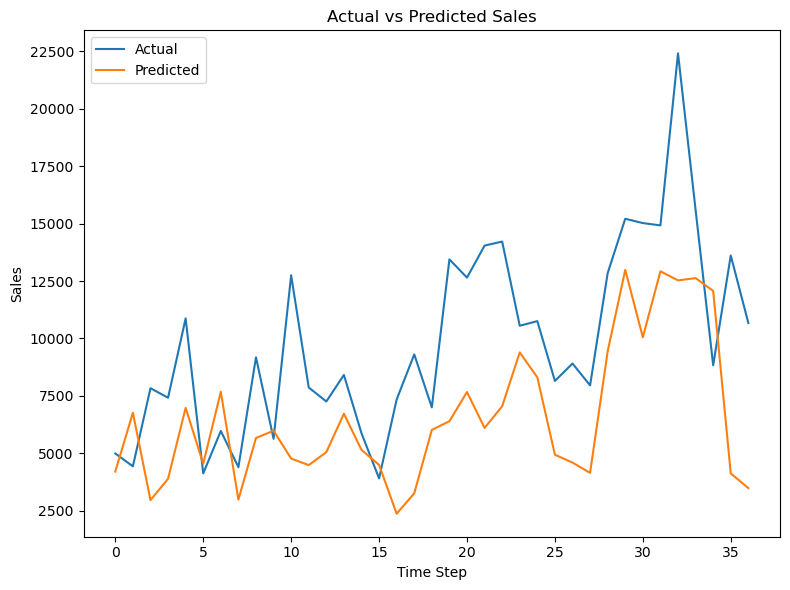

RMSE: 4540.29
MAE: 3747.70
MAPE: 36.48%


In [7]:
# Global seed & backend setup
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# (Re)start Ray
ray.shutdown()
ray.init(ignore_reinit_error=True, logging_level="ERROR")

# LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=2)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out[:, -1, :])
        return self.fc(out)

# Scale target 'Sales' separately
target_scaler = MinMaxScaler()
y_train_scaled = target_scaler.fit_transform(lstm_train[['Sales']].values)
y_test_scaled  = target_scaler.transform(lstm_test[['Sales']].values)

# Prepare feature & scaled target DataFrames
X_train_df = lstm_train.drop(columns=['Sales'])
X_test_df  = lstm_test.drop(columns=['Sales'])
y_train_df = y_train_scaled
y_test_df  = y_test_scaled

# Create sequences
SEQ_LENGTH = 4
def create_sequences(features_df, target_array, seq_length):
    X, y = [], []
    features = features_df.values
    for i in range(len(features) - seq_length):
        X.append(features[i:i+seq_length])
        y.append(target_array[i+seq_length])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(X_train_df, y_train_df, SEQ_LENGTH)
X_test, y_test   = create_sequences(X_test_df, y_test_df, SEQ_LENGTH)

# Convert to PyTorch tensors
X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.Tensor(y_train).view(-1, 1)
X_test_tensor  = torch.Tensor(X_test)
y_test_tensor  = torch.Tensor(y_test).view(-1, 1)

# Training function for Ray Tune
def train_lstm(config):
    trial_seed = config.get("seed", SEED)
    random.seed(trial_seed)
    np.random.seed(trial_seed)
    torch.manual_seed(trial_seed)
    torch.cuda.manual_seed_all(trial_seed)

    model = LSTMModel(
        input_size=X_train_tensor.shape[2],
        hidden_size=config["hidden_layer_size"]
    )
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])
    epochs = config.get("epochs", 100)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = loss_fn(preds, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)

        if epoch % 10 == 0:
            print(f"Epoch {epoch}: loss = {avg_loss:.6f}")
            with tempfile.TemporaryDirectory() as tmpdir:
                torch.save(model.state_dict(), os.path.join(tmpdir, "model.pt"))
                session.report(
                    {"loss": avg_loss},
                    checkpoint=Checkpoint.from_directory(tmpdir)
                )

# Search space and scheduler
search_space = {
    "hidden_layer_size": 128,
    "learning_rate": 0.00625042,
    "epochs": 800,
    "seed": SEED
}
scheduler = ASHAScheduler()

# RunConfig and TuneConfig
trainable = tune.with_resources(train_lstm, {"cpu": 1})
run_cfg = RunConfig(
    name="lstm_experiment",
    stop={"training_iteration": 100},
    storage_path=str(pathlib.Path("E:/datasets/ray_results").resolve()),
    sync_config=None,
    log_to_file=False
)
tune_cfg = TuneConfig(
    metric="loss",
    mode="min",
    num_samples=100,
    scheduler=scheduler
)

# Run the tuner
tuner = tune.Tuner(
    trainable,
    run_config=run_cfg,
    tune_config=tune_cfg,
    param_space=search_space
)
results = tuner.fit()

# Load best model and evaluate
best = results.get_best_result(metric="loss", mode="min")
print("Best hyperparameters:", best.config)
ckpt_dir = best.checkpoint.to_directory()

best_model = LSTMModel(
    input_size=X_train_tensor.shape[2],
    hidden_size=best.config["hidden_layer_size"]
)
best_model.load_state_dict(torch.load(os.path.join(ckpt_dir, "model.pt")))
best_model.eval()

# Predictions and inverse transform
with torch.no_grad():
    y_pred_scaled = best_model(X_test_tensor).numpy()
    y_pred = target_scaler.inverse_transform(y_pred_scaled)
    y_true = target_scaler.inverse_transform(y_test_tensor.numpy())

# Plot
plt.figure(figsize=(8, 6))
plt.plot(range(len(y_true)), y_true, label="Actual", color="tab:blue")
plt.plot(range(len(y_pred)), y_pred, label="Predicted", color="tab:orange")
plt.legend()
plt.title("Actual vs Predicted Sales")
plt.xlabel("Time Step")
plt.ylabel("Sales")
plt.tight_layout()
plt.show()

# Metrics
def root_mean_squared_error(y_t, y_p):
    return np.sqrt(mean_squared_error(y_t, y_p))

rmse = root_mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1e-8))) * 100

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")


Note that within the search space section of the code there are single values for each hyperparameter, but a proper hyperparameter search was performed before selecting individual values. Despite setting a seed, there is a bit of randomization within ray that cannot be fixed - you may get different results for different ranges of hyperparameters, e.g., 600 may be the best number of epochs for one particular run, but not after reducing the range of hidden layer sizes.

After many iterations, the hyperparameters I chose were the most consistent performers of all combinations.

Due to hardware and time constraints, only a ~10% sample of the full dataset was used to train the LSTM model. Evaluation checkpoints during training were omitted, as each would have added ~2.5 hours to the already lengthy training process — full-data training was estimated to take three months. With more computing resources, I would have used the full dataset and incorporated validation every 20 epochs to identify the point of diminishing returns from training.

Despite these limitations, the LSTM model showed learning progress (as seen in the training plot). However, its 36.48% MAPE indicates it underperformed compared to the SARIMA and SARIMAX models. It's worth noting the LSTM model was trained on weekly resampled data, which may have introduced greater noise than the monthly data used in the other models.

### Recommendations

Based on the results, the SARIMA model is recommended as the best choice due to its strong forecasting performance and simplicity — it effectively captured seasonality and autocorrelation using just lags 1 and 12, without requiring exogenous variables.

For future modeling efforts, model performance could be revisited using different temporal granularities (e.g., daily or weekly data) depending on business needs. Furthermore, incorporating additional features such as holiday effects, promotional activity, or pricing data may significantly improve the performance of the SARIMAX and LSTM models, potentially surpassing the SARIMA baseline.